In [180]:
#import libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from yahoo_fin import stock_info

In [181]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization

In [8]:
#Import data
tcsweekly = stock_info.get_data("RELIANCE.NS", interval="1d")
tcsweekly = tcsweekly.drop(['ticker'], axis=1)
tcsweekly=tcsweekly.dropna() #Remove Null Values
tcsweekly = tcsweekly[:-1]
tcsweekly

open         high          low        close     adjclose  \
1996-01-01    15.859429    15.944529    15.754989    15.917452    10.477991   
1996-01-02    15.878770    15.956133    15.677626    15.793671    10.396509   
1996-01-03    16.052837    16.783918    15.878770    15.913584    10.475443   
1996-01-04    15.762726    15.813012    15.553845    15.766594    10.378686   
1996-01-05    15.704703    15.704703    15.522900    15.658285    10.307389   
...                 ...          ...          ...          ...          ...   
2023-04-20  2354.100098  2359.000000  2332.100098  2346.050049  2346.050049   
2023-04-21  2350.649902  2361.000000  2336.399902  2349.000000  2349.000000   
2023-04-24  2375.000000  2380.899902  2348.000000  2358.000000  2358.000000   
2023-04-25  2366.000000  2380.600098  2350.500000  2376.050049  2376.050049   
2023-04-26  2379.000000  2386.100098  2354.050049  2362.100098  2362.100098   

                 volume  
1996-01-01   48051995.0  
1996-01-02   77875009.0  
1996-01-03   96602936.0  
1996-01-04  100099436.0  
1996-01-05   76935930.0  
...                 ...  
2023-04-20    3233882.0  
2023-04-21    3529236.0  
2023-04-24    5970048.0  
2023-04-25    4262471.0  
2023-04-26    3977129.0  

[6867 rows x 6 columns]

In [190]:
df = tcsweekly
df['close']

1996-01-01      15.917452
1996-01-02      15.793671
1996-01-03      15.913584
1996-01-04      15.766594
1996-01-05      15.658285
                 ...     
2023-04-20    2346.050049
2023-04-21    2349.000000
2023-04-24    2358.000000
2023-04-25    2376.050049
2023-04-26    2362.100098
Name: close, Length: 6867, dtype: float64

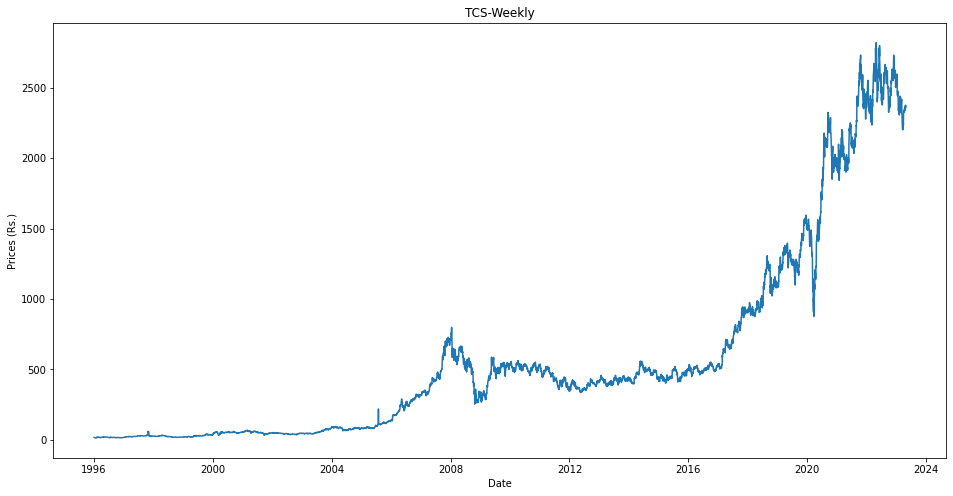

In [3]:
#Plot the graph
plt.figure(figsize=(16,8))
plt.plot(tcsweekly['close'])
plt.title('TCS-Weekly')
plt.xlabel('Date')
plt.ylabel('Prices (Rs.)')
plt.show()

6867
6867
6502


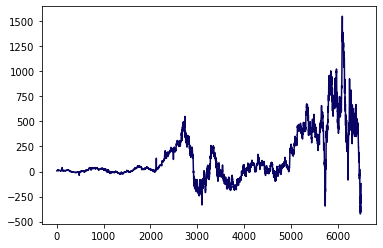

In [194]:
X = df['close'].values
diff = list()
days_in_year = 365

print(len(X))

for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)

print(len(diff))

plt.plot(diff)
plt.show()

<Figure size 432x288 with 0 Axes>

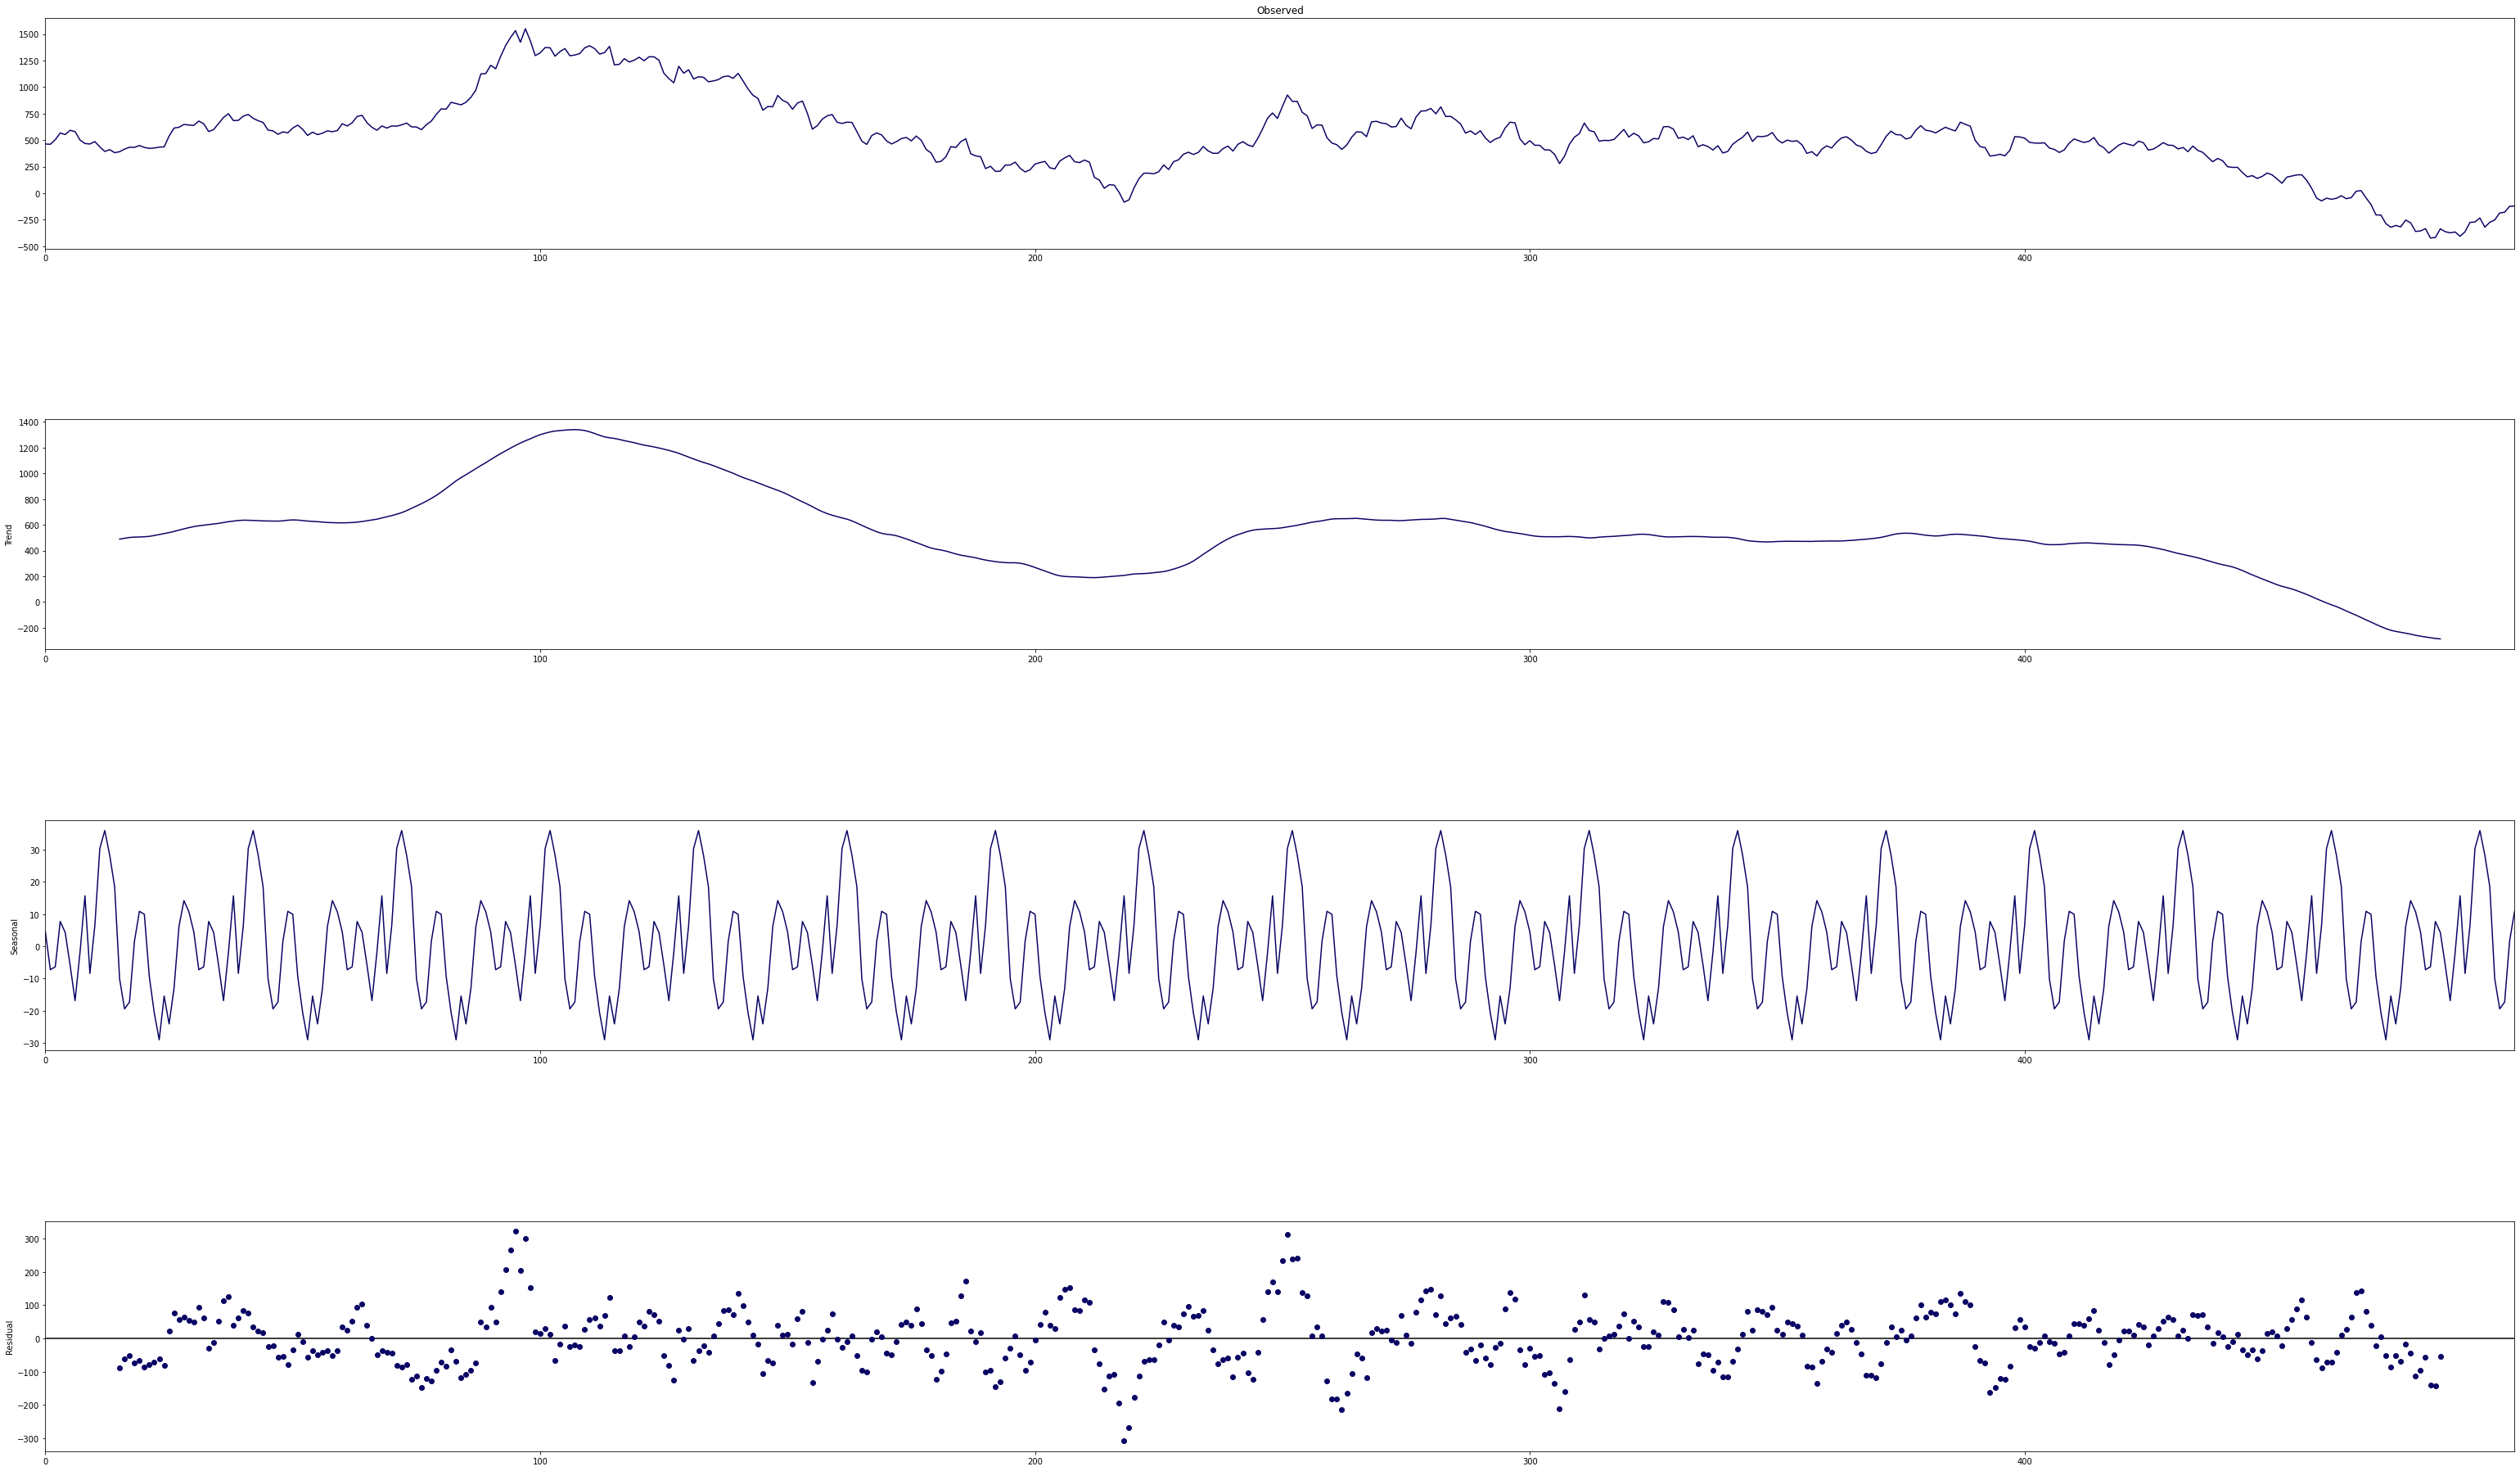

In [198]:
decompose_result = seasonal_decompose(diff[-500:], period=30)
fig=plt.figure()
fig=decompose_result.plot()
fig.set_size_inches(50,30)

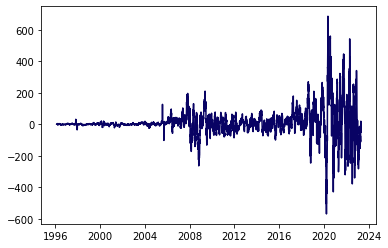

In [201]:
seas_diff = data['close'].diff(periods=30)
plt.plot(seas_diff)
plt.show()

<Figure size 432x288 with 0 Axes>

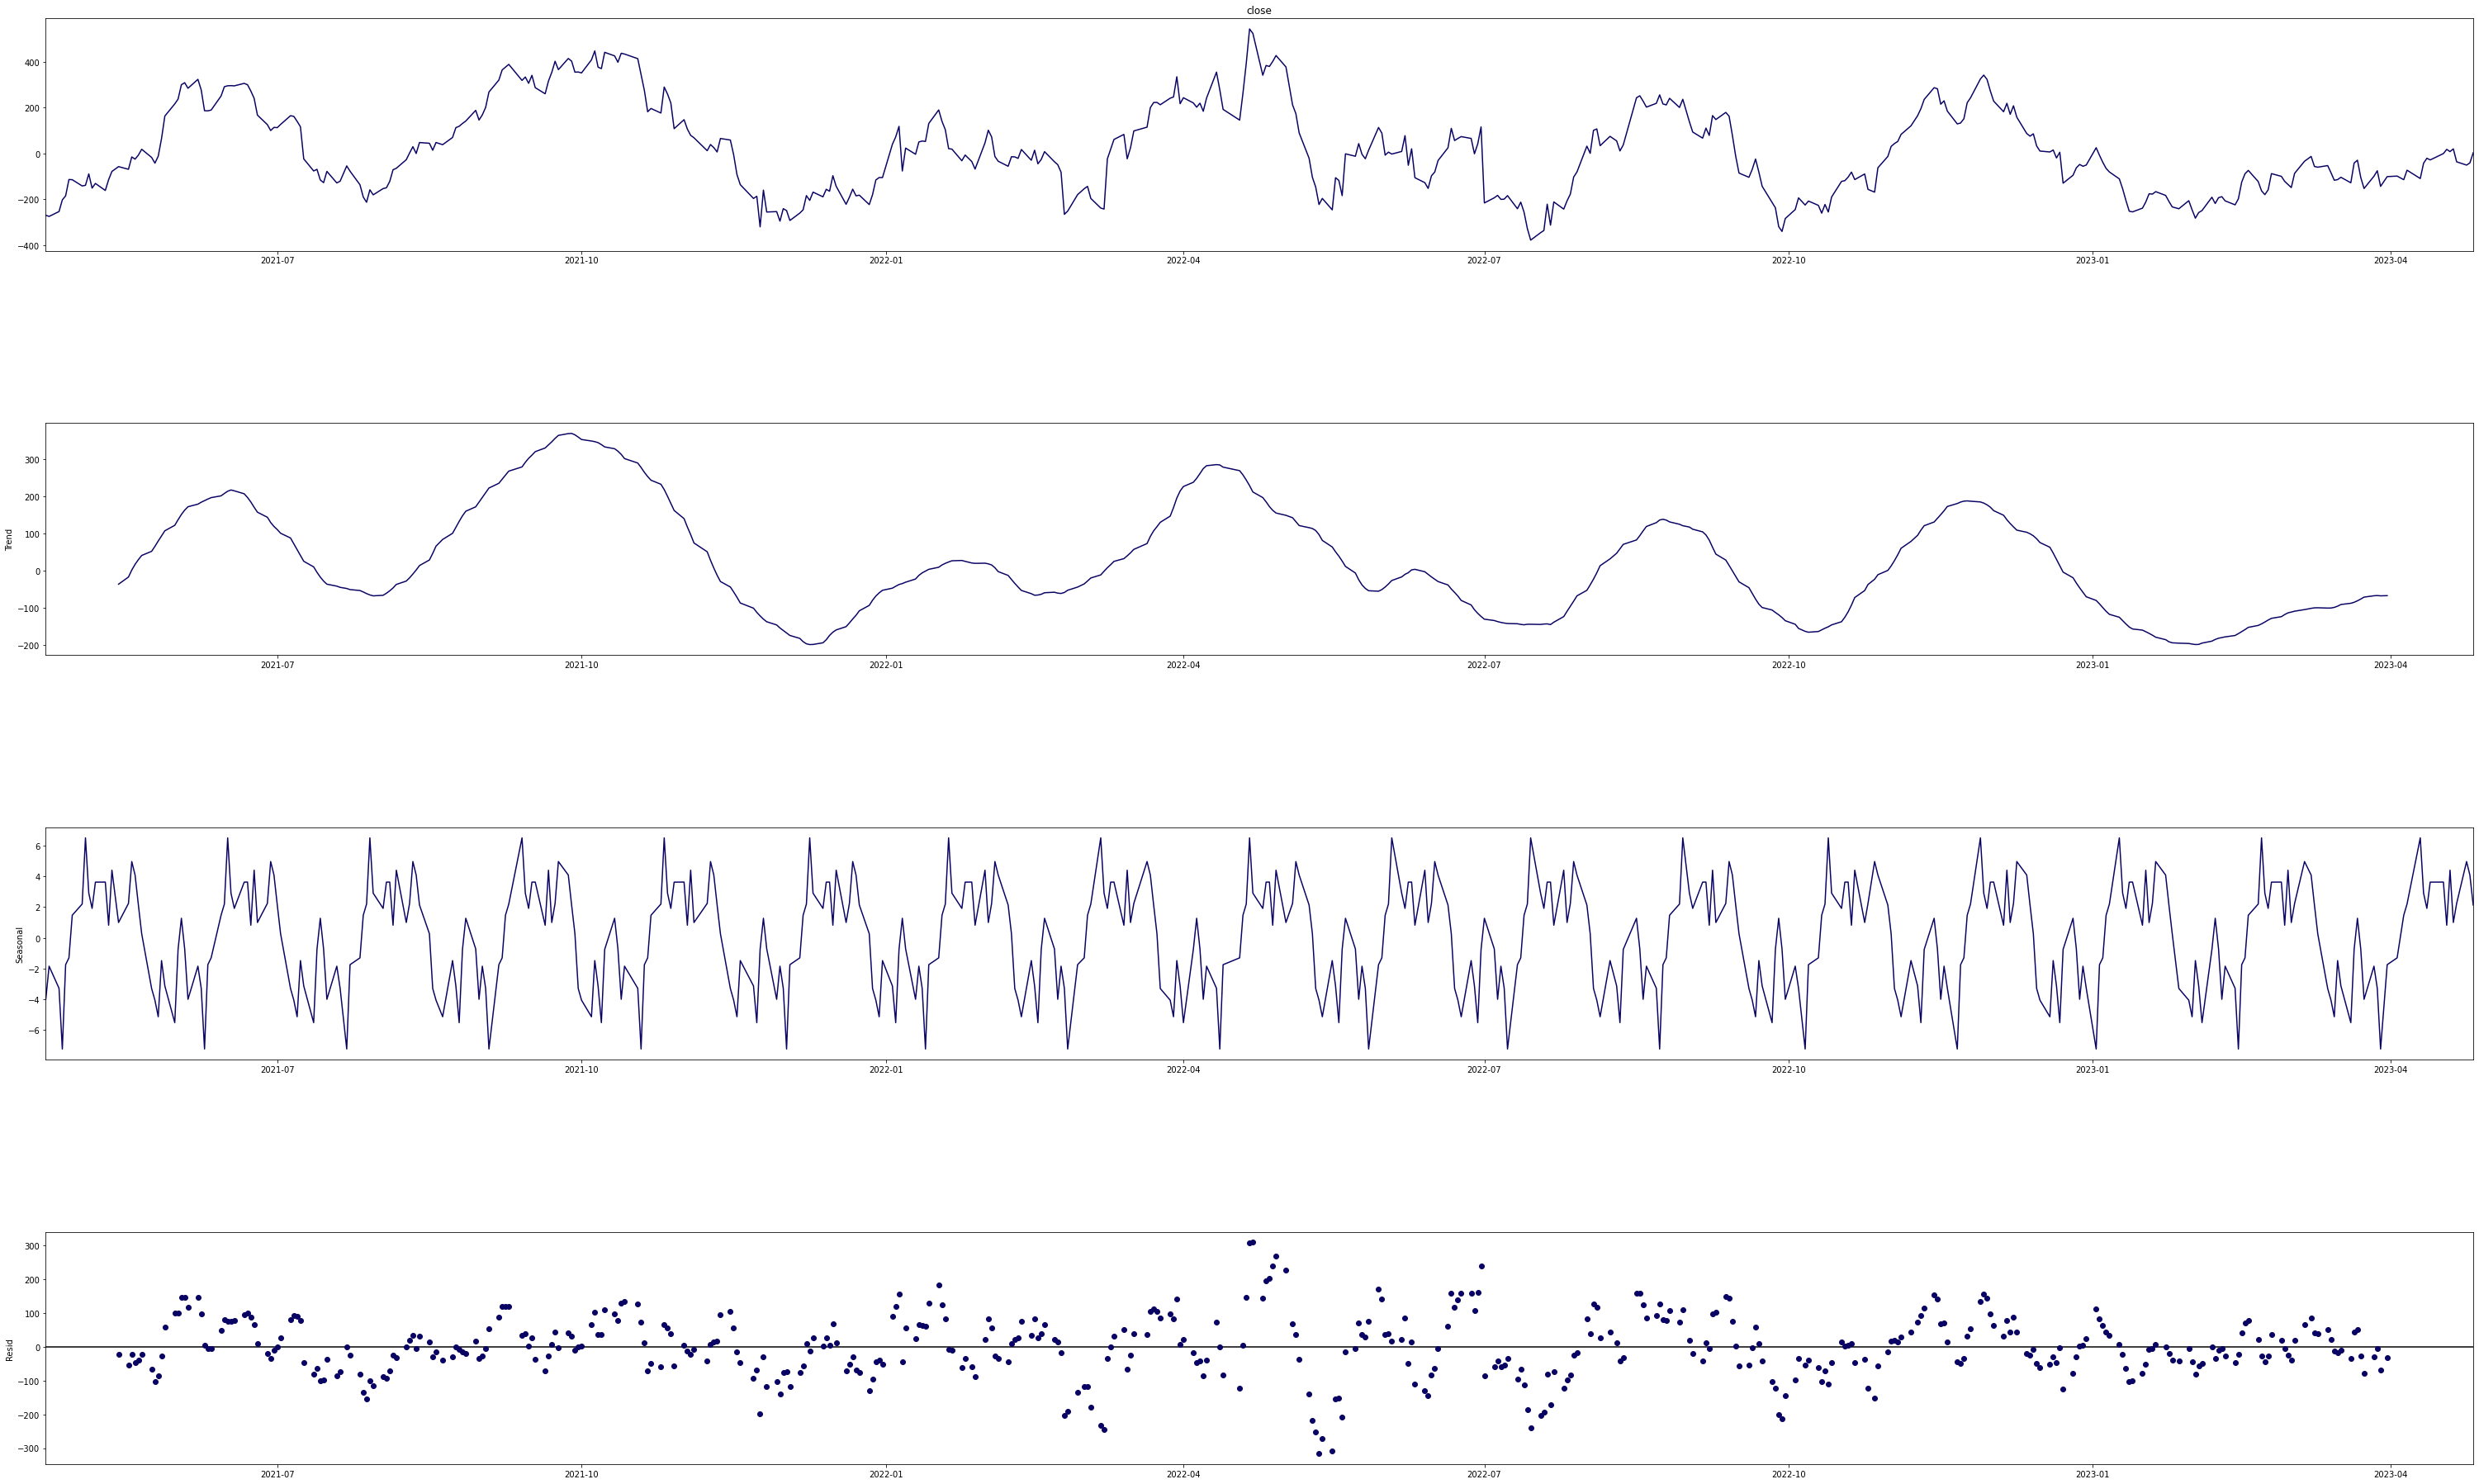

In [202]:
decompose_result = seasonal_decompose(seas_diff[-500:], period=30)
fig=plt.figure()
fig=decompose_result.plot()
fig.set_size_inches(50,30)

In [12]:
train_df = tcsweekly.copy()

# List of considered Features
FEATURES = ['high', 'low', 'open', 'close', 'volume']

print('FEATURE LIST')

print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['prediction'] = data_filtered_ext['close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['high', 'low', 'open', 'close', 'volume']


high          low         open        close     volume  \
2023-04-20  2359.000000  2332.100098  2354.100098  2346.050049  3233882.0   
2023-04-21  2361.000000  2336.399902  2350.649902  2349.000000  3529236.0   
2023-04-24  2380.899902  2348.000000  2375.000000  2358.000000  5970048.0   
2023-04-25  2380.600098  2350.500000  2366.000000  2376.050049  4262471.0   
2023-04-26  2386.100098  2354.050049  2379.000000  2362.100098  3977129.0   

             prediction  
2023-04-20  2346.050049  
2023-04-21  2349.000000  
2023-04-24  2358.000000  
2023-04-25  2376.050049  
2023-04-26  2362.100098

In [14]:
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(6867, 5)


In [15]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(5444, 50, 5) (5444,)
(1373, 50, 5) (1373,)
0.0018225214084461715
0.0018225214084461715


In [18]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

2023-04-28 00:44:18.913180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


250 50 5


In [22]:
epochs = 10
batch_size = 100
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
55/55 [==============================] - 44s 791ms/step - loss: 2.2075e-05 - val_loss: 7.6242e-04
Epoch 2/10
55/55 [==============================] - 45s 814ms/step - loss: 2.1467e-05 - val_loss: 7.3941e-04
Epoch 3/10
55/55 [==============================] - 52s 943ms/step - loss: 2.2300e-05 - val_loss: 7.5060e-04
Epoch 4/10
55/55 [==============================] - 46s 837ms/step - loss: 2.1143e-05 - val_loss: 9.7260e-04
Epoch 5/10
55/55 [==============================] - 49s 888ms/step - loss: 2.0786e-05 - val_loss: 6.0287e-04
Epoch 6/10
55/55 [==============================] - 50s 914ms/step - loss: 2.1705e-05 - val_loss: 7.1148e-04
Epoch 7/10
55/55 [==============================] - 44s 802ms/step - loss: 2.0552e-05 - val_loss: 6.6548e-04
Epoch 8/10
55/55 [==============================] - 48s 875ms/step - loss: 2.0513e-05 - val_loss: 0.0011
Epoch 9/10
55/55 [==============================] - 46s 841ms/step - loss: 2.1827e-05 - val_loss: 0.0015
Epoch 10/10
55/55 [========

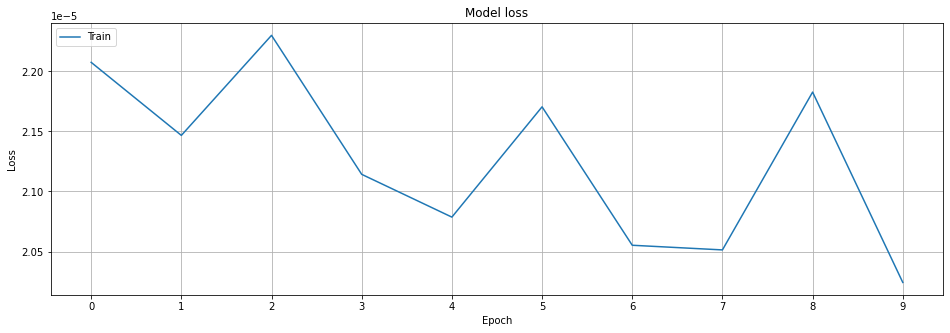

In [23]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [24]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

43/43 [==============================] - 6s 106ms/step
Median Absolute Error (MAE): 61.38
Mean Absolute Percentage Error (MAPE): 3.28 %
Median Absolute Percentage Error (MDAPE): 2.97 %


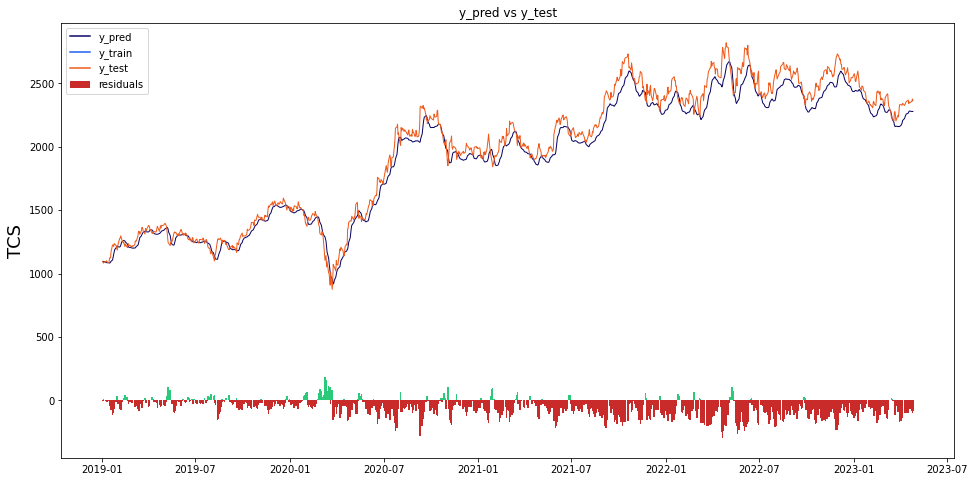

In [37]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['close'][:train_data_len + 1]).rename(columns={'close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['close'][train_data_len:]).rename(columns={'close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('TCS', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [36]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for TCS at today was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 59ms/step
The close price for TCS at today was 2362.1
The predicted close price is 2280.31005859375 (-3.59%)


<Figure size 432x288 with 0 Axes>

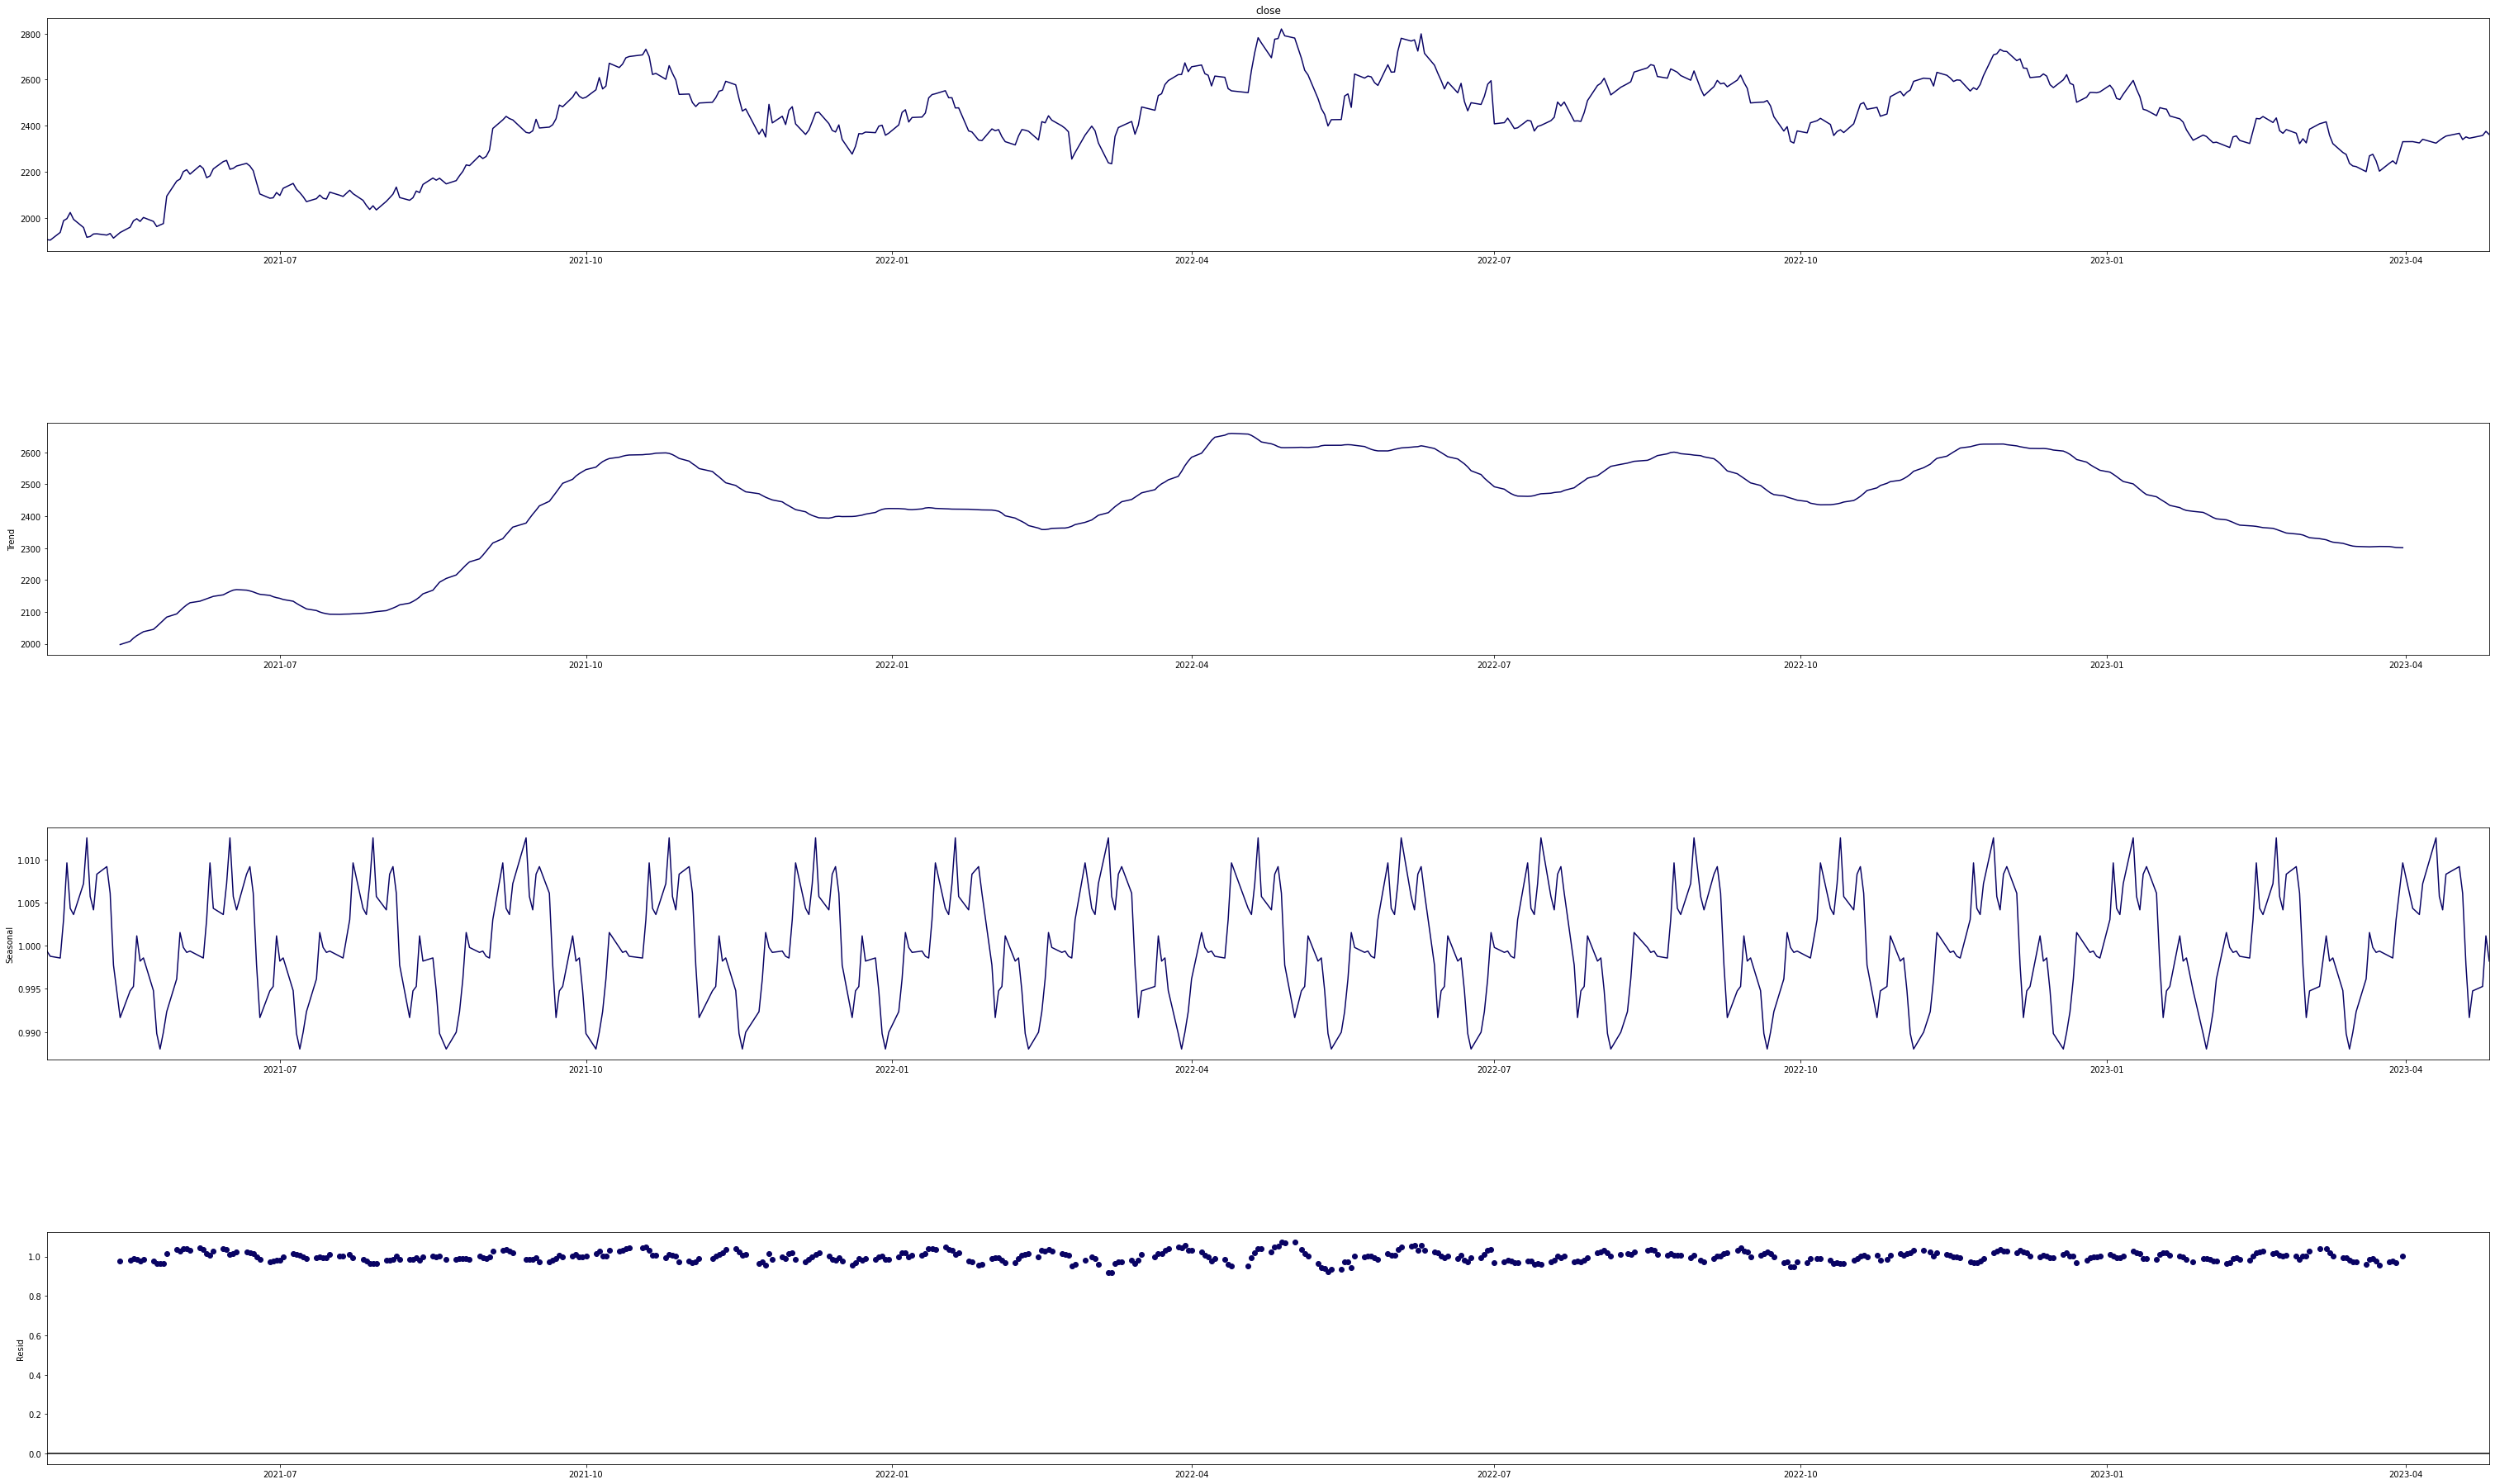

In [79]:
df = tcsweekly
df = df.tail(500)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=30)
fig=plt.figure()
fig=decomposition.plot()
fig.set_size_inches(50,30)

<Figure size 432x288 with 0 Axes>

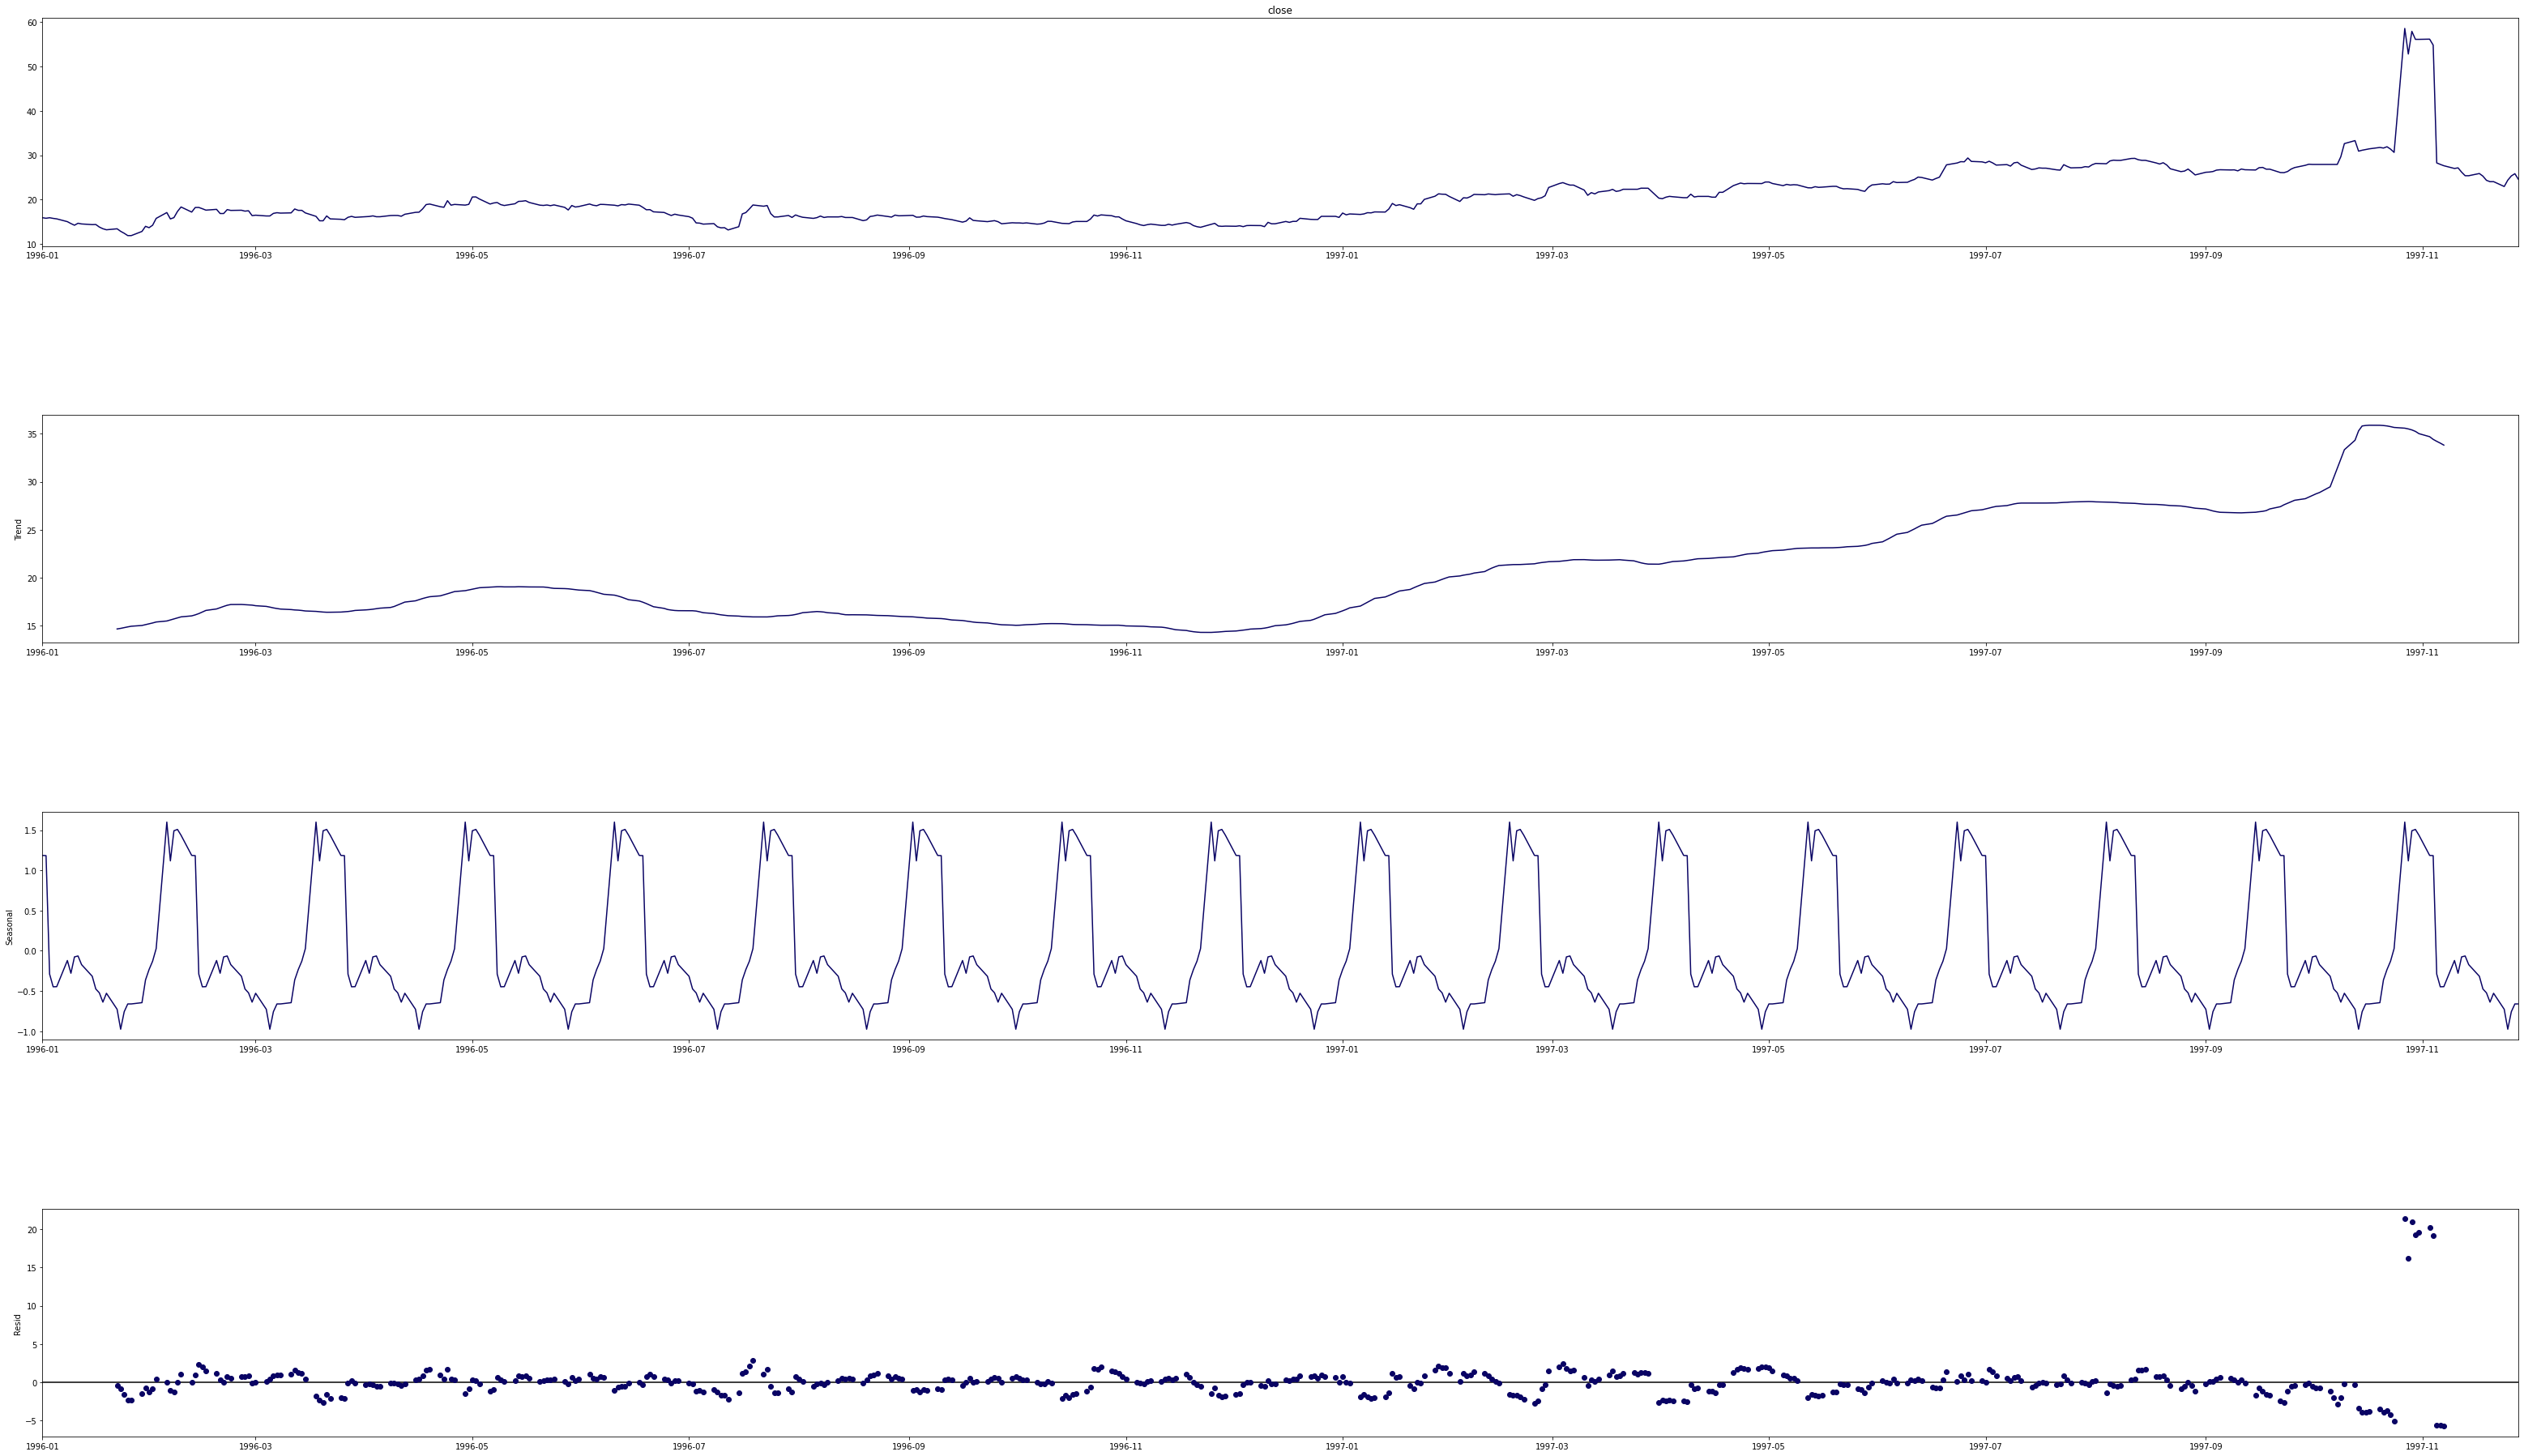

In [81]:
df = tcsweekly
df = df.head(500)
result = seasonal_decompose(df['close'], model='additive', period=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(50,30)

In [123]:
import plotly.express as px
import pandas as pd

# Read in the data
data = tcsweekly


def plotting(title, data, x, y, x_label, y_label):
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18),title_text=title, width=650,title_x=0.5, height=400)
    fig.show()

# Plot the airline passenger data
plotting(title='TCS', data=data, x='date', y='close', x_label='Date', y_label='Price')

In [129]:
data["seas_diff"] = data['close'].diff(periods=2)
plotting(title='TCS', data=data, x='date', y='seas_diff', x_label='Date', y_label='Close Price SD')

<Figure size 432x288 with 0 Axes>

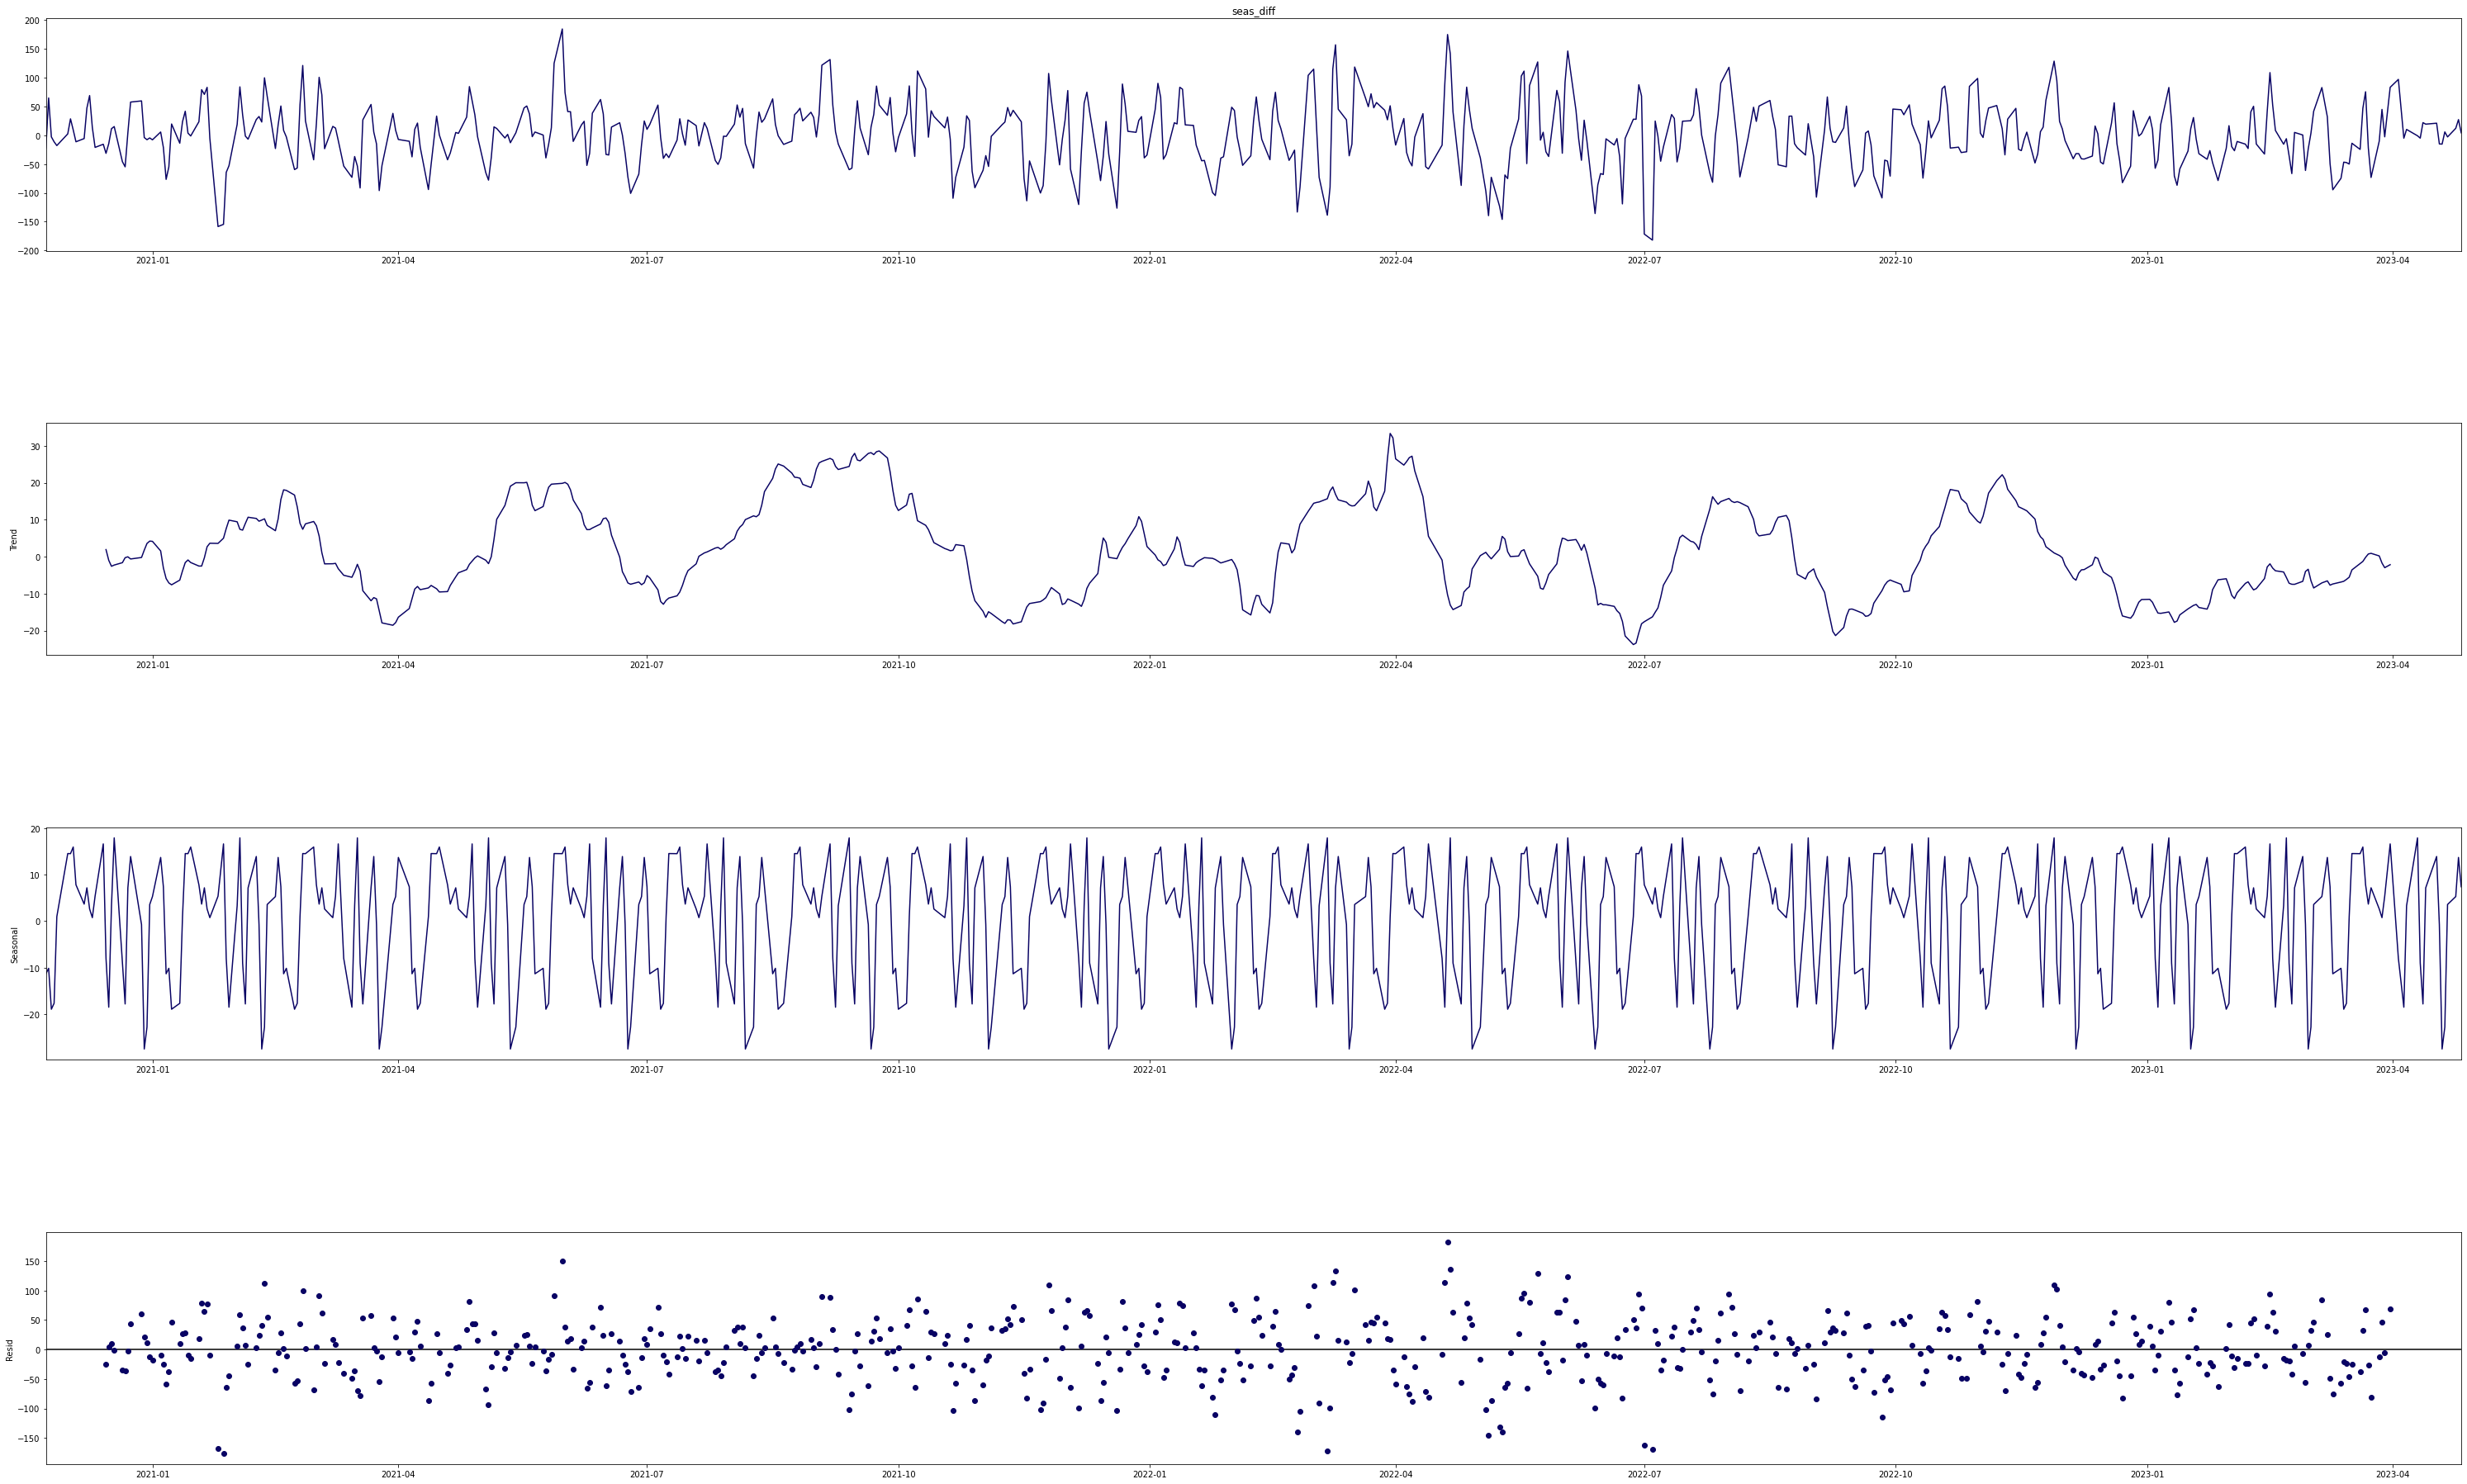

In [141]:
df = data.tail(600)
result = seasonal_decompose(df['seas_diff'], model='additive', period=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(50,30)

In [130]:
from statsmodels.tsa.stattools import adfuller


def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(data["seas_diff"][12:])

ADF Statistic:  -15.43239796559225
P-Value:  2.936793856455689e-28
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [43]:
!pip3 install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 1.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 4.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [89]:
data.index.values

array(['1996-01-01T00:00:00.000000000', '1996-01-02T00:00:00.000000000',
       '1996-01-03T00:00:00.000000000', ...,
       '2023-04-24T00:00:00.000000000', '2023-04-25T00:00:00.000000000',
       '2023-04-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [92]:
data['close']

1996-01-01      15.917452
1996-01-02      15.793671
1996-01-03      15.913584
1996-01-04      15.766594
1996-01-05      15.658285
                 ...     
2023-04-20    2346.050049
2023-04-21    2349.000000
2023-04-24    2358.000000
2023-04-25    2376.050049
2023-04-26    2362.100098
Name: close, Length: 6867, dtype: float64

In [98]:
data['date'] = data.index 

In [101]:
data['date']

1996-01-01   1996-01-01
1996-01-02   1996-01-02
1996-01-03   1996-01-03
1996-01-04   1996-01-04
1996-01-05   1996-01-05
                ...    
2023-04-20   2023-04-20
2023-04-21   2023-04-21
2023-04-24   2023-04-24
2023-04-25   2023-04-25
2023-04-26   2023-04-26
Name: date, Length: 6867, dtype: datetime64[ns]

In [103]:
data.reset_index()

index         open         high          low        close  \
0    1996-01-01    15.859429    15.944529    15.754989    15.917452   
1    1996-01-02    15.878770    15.956133    15.677626    15.793671   
2    1996-01-03    16.052837    16.783918    15.878770    15.913584   
3    1996-01-04    15.762726    15.813012    15.553845    15.766594   
4    1996-01-05    15.704703    15.704703    15.522900    15.658285   
...         ...          ...          ...          ...          ...   
6862 2023-04-20  2354.100098  2359.000000  2332.100098  2346.050049   
6863 2023-04-21  2350.649902  2361.000000  2336.399902  2349.000000   
6864 2023-04-24  2375.000000  2380.899902  2348.000000  2358.000000   
6865 2023-04-25  2366.000000  2380.600098  2350.500000  2376.050049   
6866 2023-04-26  2379.000000  2386.100098  2354.050049  2362.100098   

         adjclose       volume       date  
0       10.477991   48051995.0 1996-01-01  
1       10.396509   77875009.0 1996-01-02  
2       10.475443   96602936.0 1996-01-03  
3       10.378686  100099436.0 1996-01-04  
4       10.307389   76935930.0 1996-01-05  
...           ...          ...        ...  
6862  2346.050049    3233882.0 2023-04-20  
6863  2349.000000    3529236.0 2023-04-21  
6864  2358.000000    5970048.0 2023-04-24  
6865  2376.050049    4262471.0 2023-04-25  
6866  2362.100098    3977129.0 2023-04-26  

[6867 rows x 8 columns]

In [126]:
data

open         high          low        close     adjclose  \
1996-01-01    15.859429    15.944529    15.754989    15.917452    10.477991   
1996-01-02    15.878770    15.956133    15.677626    15.793671    10.396509   
1996-01-03    16.052837    16.783918    15.878770    15.913584    10.475443   
1996-01-04    15.762726    15.813012    15.553845    15.766594    10.378686   
1996-01-05    15.704703    15.704703    15.522900    15.658285    10.307389   
...                 ...          ...          ...          ...          ...   
2023-04-20  2354.100098  2359.000000  2332.100098  2346.050049  2346.050049   
2023-04-21  2350.649902  2361.000000  2336.399902  2349.000000  2349.000000   
2023-04-24  2375.000000  2380.899902  2348.000000  2358.000000  2358.000000   
2023-04-25  2366.000000  2380.600098  2350.500000  2376.050049  2376.050049   
2023-04-26  2379.000000  2386.100098  2354.050049  2362.100098  2362.100098   

                 volume       date  Passenger_Season_Diff   seas_diff  
1996-01-01   48051995.0 1996-01-01                    NaN         NaN  
1996-01-02   77875009.0 1996-01-02                    NaN         NaN  
1996-01-03   96602936.0 1996-01-03              -0.003868         NaN  
1996-01-04  100099436.0 1996-01-04              -0.027077         NaN  
1996-01-05   76935930.0 1996-01-05              -0.255299         NaN  
...                 ...        ...                    ...         ...  
2023-04-20    3233882.0 2023-04-20               5.699951 -434.399902  
2023-04-21    3529236.0 2023-04-21              -3.000000 -344.649902  
2023-04-24    5970048.0 2023-04-24              11.949951 -282.899902  
2023-04-25    4262471.0 2023-04-25              27.050049 -244.599854  
2023-04-26    3977129.0 2023-04-26               4.100098 -156.199951  

[6867 rows x 9 columns]

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: 0.802466
p-value: 0.991676
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 8.859538
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1987: FutureWarning:

None is not a valid value for nlags. It must be an integer, 'auto' or 'legacy'. None will raise starting in 0.14

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




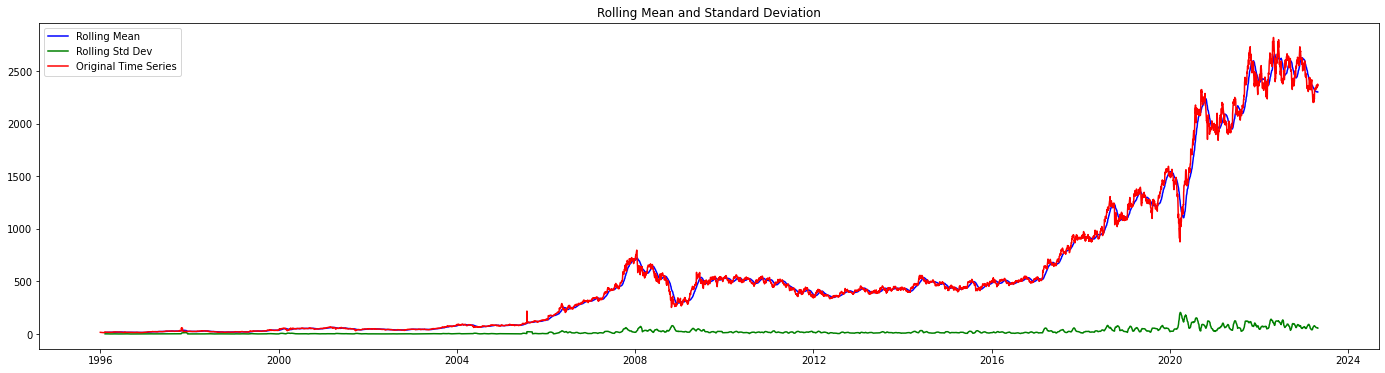

In [132]:
#Testing for stationarity using ADF and KPSS Tests.

from statsmodels.tsa.stattools import kpss

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='red',label='Original Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(data['close'])

#p-value should be >0.05 in ADF and <0.05 in KPSS to prove non-stationarity

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -9.546327
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.422037
p-value: 0.067656
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1987: FutureWarning:

None is not a valid value for nlags. It must be an integer, 'auto' or 'legacy'. None will raise starting in 0.14

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



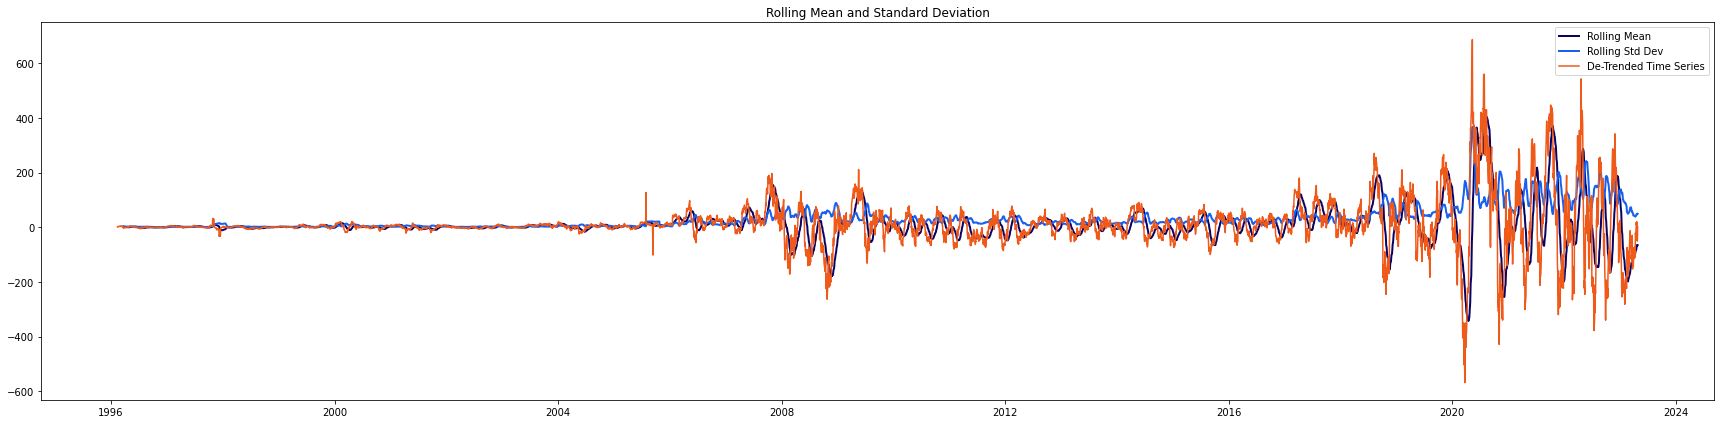

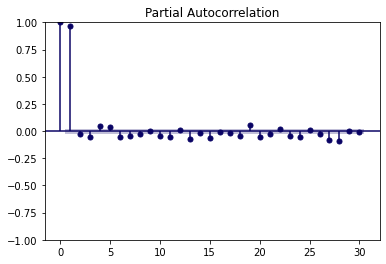

In [135]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
data['Close_Detrend'] = (data['close'] - data['close'].shift(30))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(data['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(data['Close_Detrend'].dropna(), lags=30)

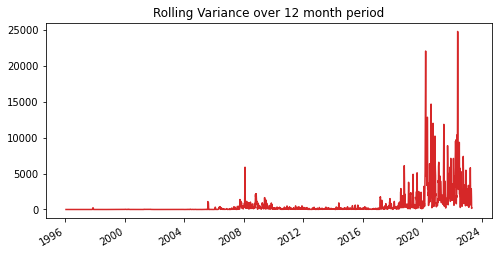

In [142]:
data['close'].rolling(window = 12).var().plot(figsize=(8,4), color="tab:red", title="Rolling Variance over 12 month period");

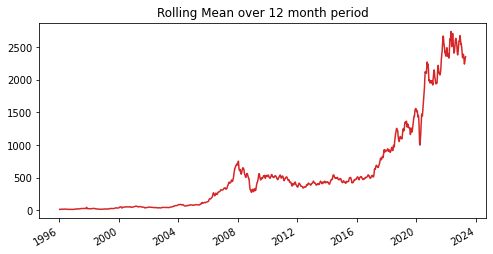

In [143]:
data['close'].rolling(window = 12).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 12 month period");

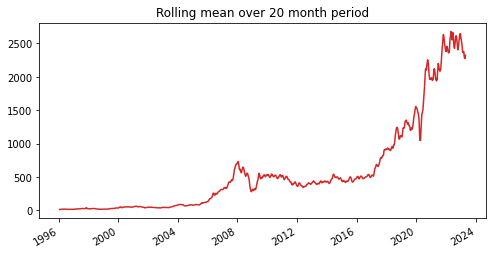

In [144]:
data['close'].rolling(window = 20).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over 20 month period");

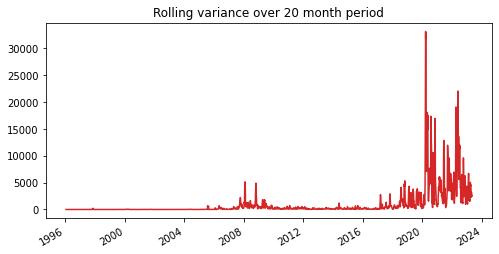

In [145]:
data['close'].rolling(window = 20).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over 20 month period");

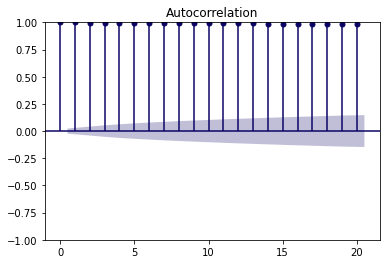

In [158]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(data['close'], lags=20);

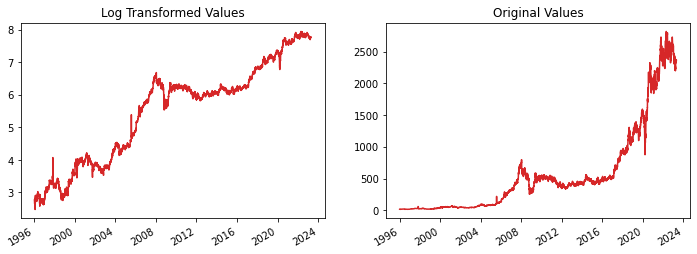

In [160]:
logged_passengers = data['close'].apply(lambda x : np.log(x))

ax1 = plt.subplot(121)
logged_passengers.plot(figsize=(12,4) ,color="tab:red", title="Log Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
data['close'].plot(color="tab:red", title="Original Values", ax=ax2);

<Figure size 432x288 with 0 Axes>

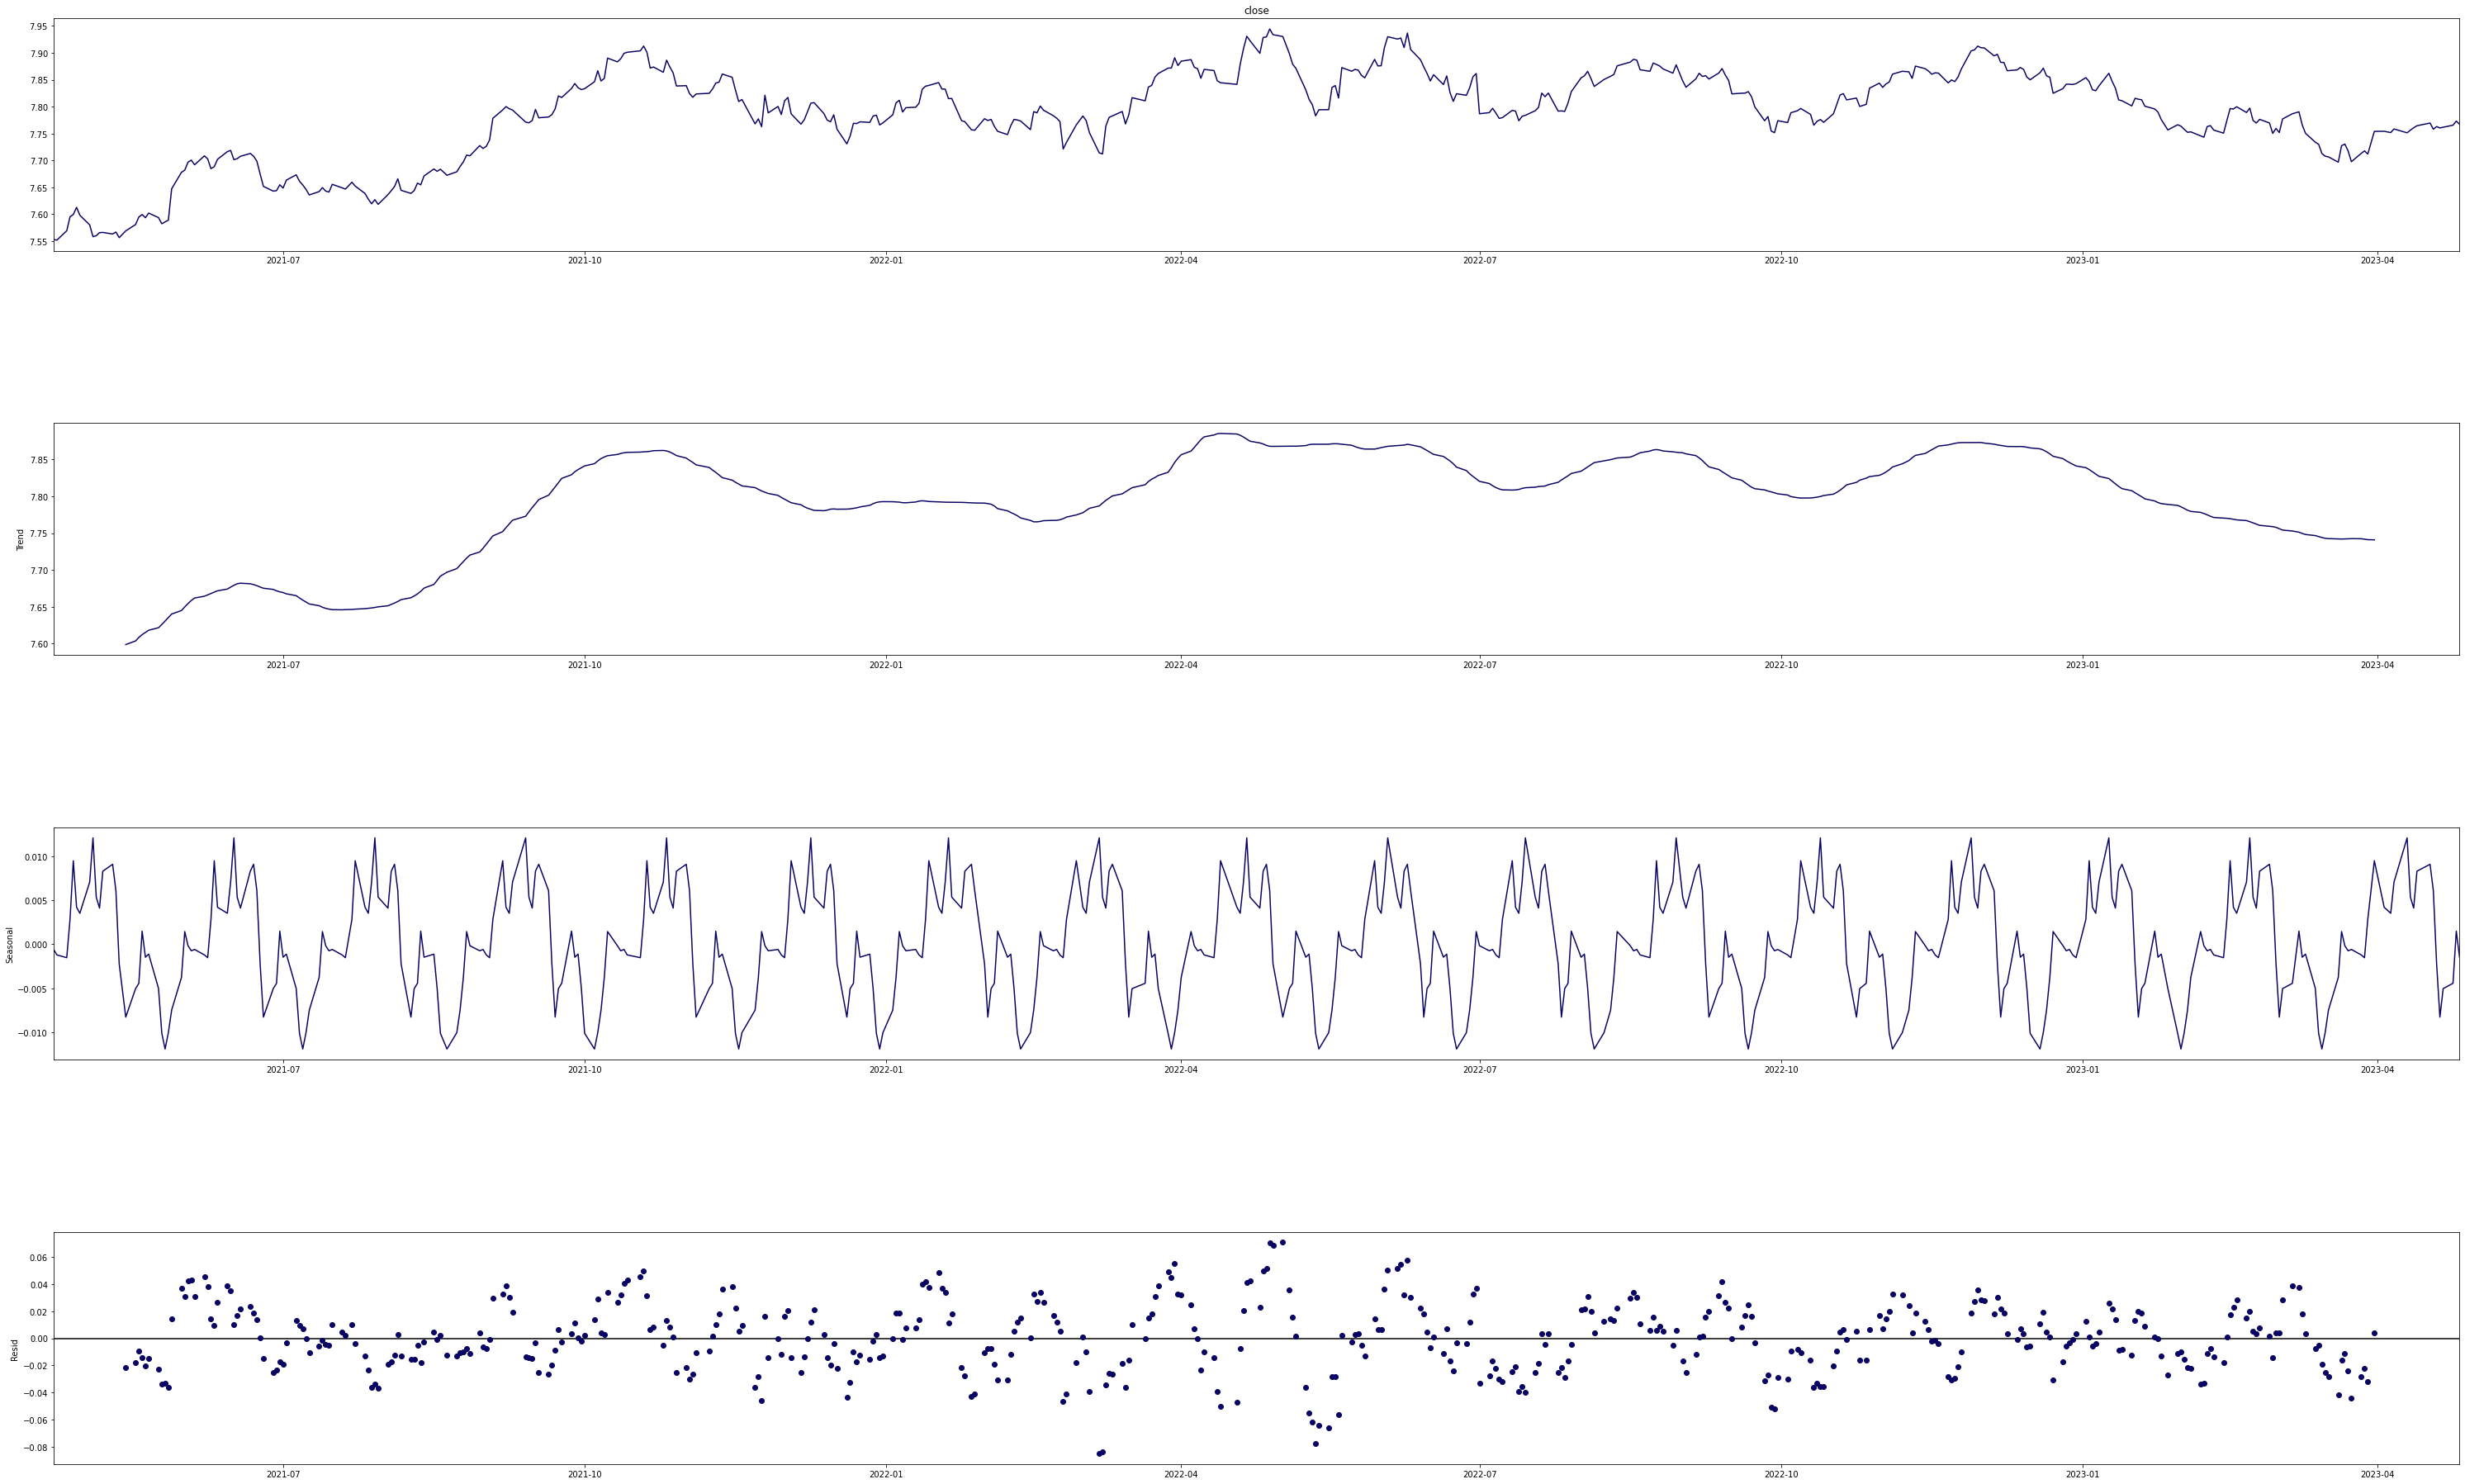

In [170]:
decompose_result = seasonal_decompose(logged_passengers.tail(500), period=30)
fig=plt.figure()
fig=decompose_result.plot()
fig.set_size_inches(50,30)

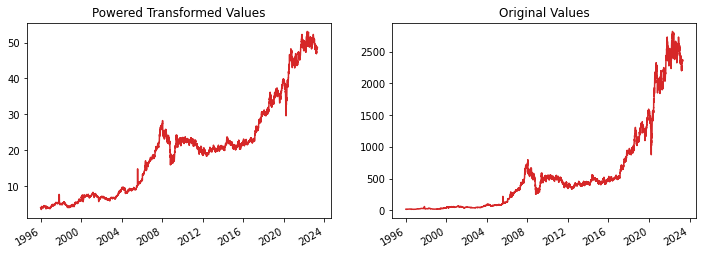

In [171]:
powered_passengers = data['close'].apply(lambda x : x ** 0.5)

ax1 = plt.subplot(121)
powered_passengers.plot(figsize=(12,4), color="tab:red", title="Powered Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
data['close'].plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

<Figure size 432x288 with 0 Axes>

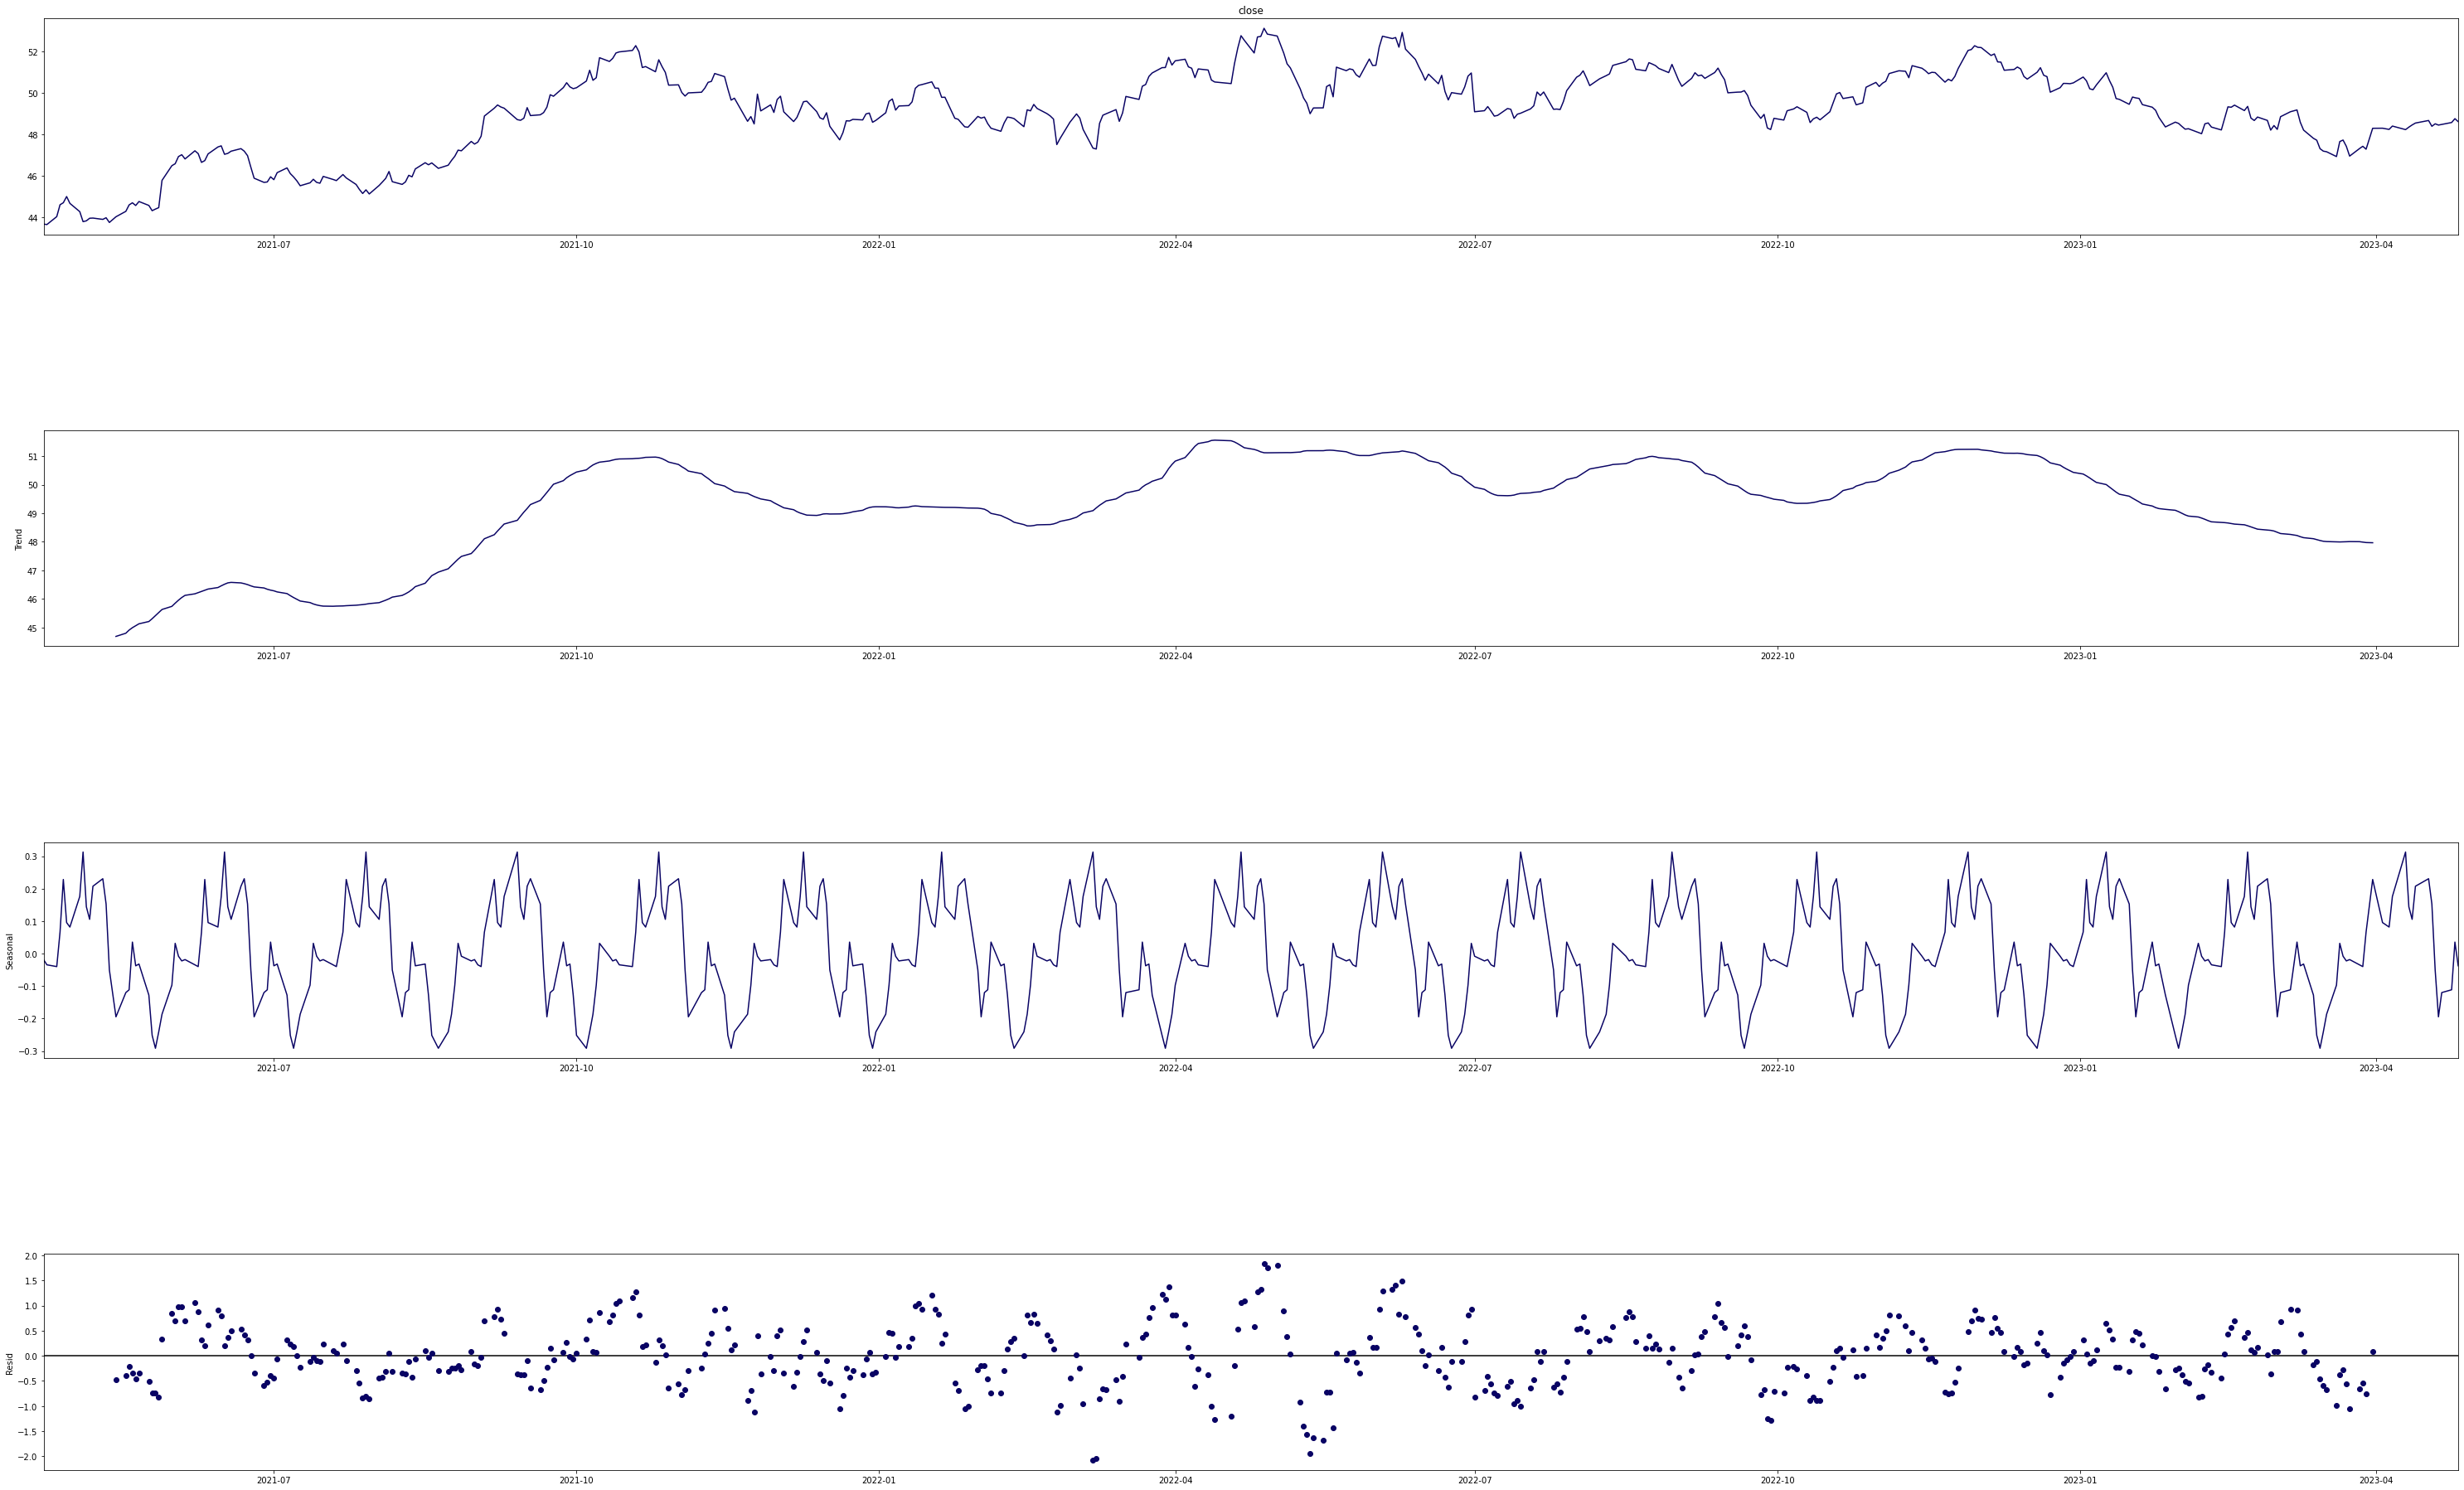

In [172]:
decompose_result = seasonal_decompose(powered_passengers.tail(500), period=30)
fig=plt.figure()
fig=decompose_result.plot()
fig.set_size_inches(50,30)

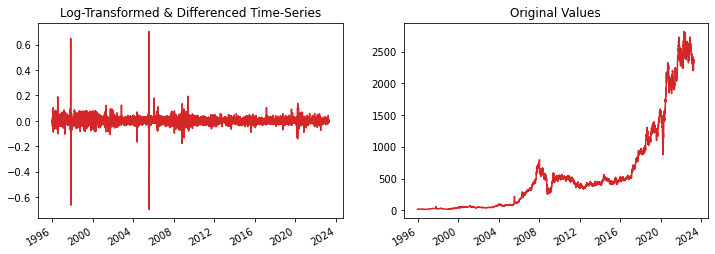

In [173]:
logged_passengers_diff = logged_passengers - logged_passengers.shift()

ax1 = plt.subplot(121)
logged_passengers_diff.plot(figsize=(12,4), color="tab:red", title="Log-Transformed & Differenced Time-Series", ax=ax1)
ax2 = plt.subplot(122)
data['close'].plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

<Figure size 432x288 with 0 Axes>

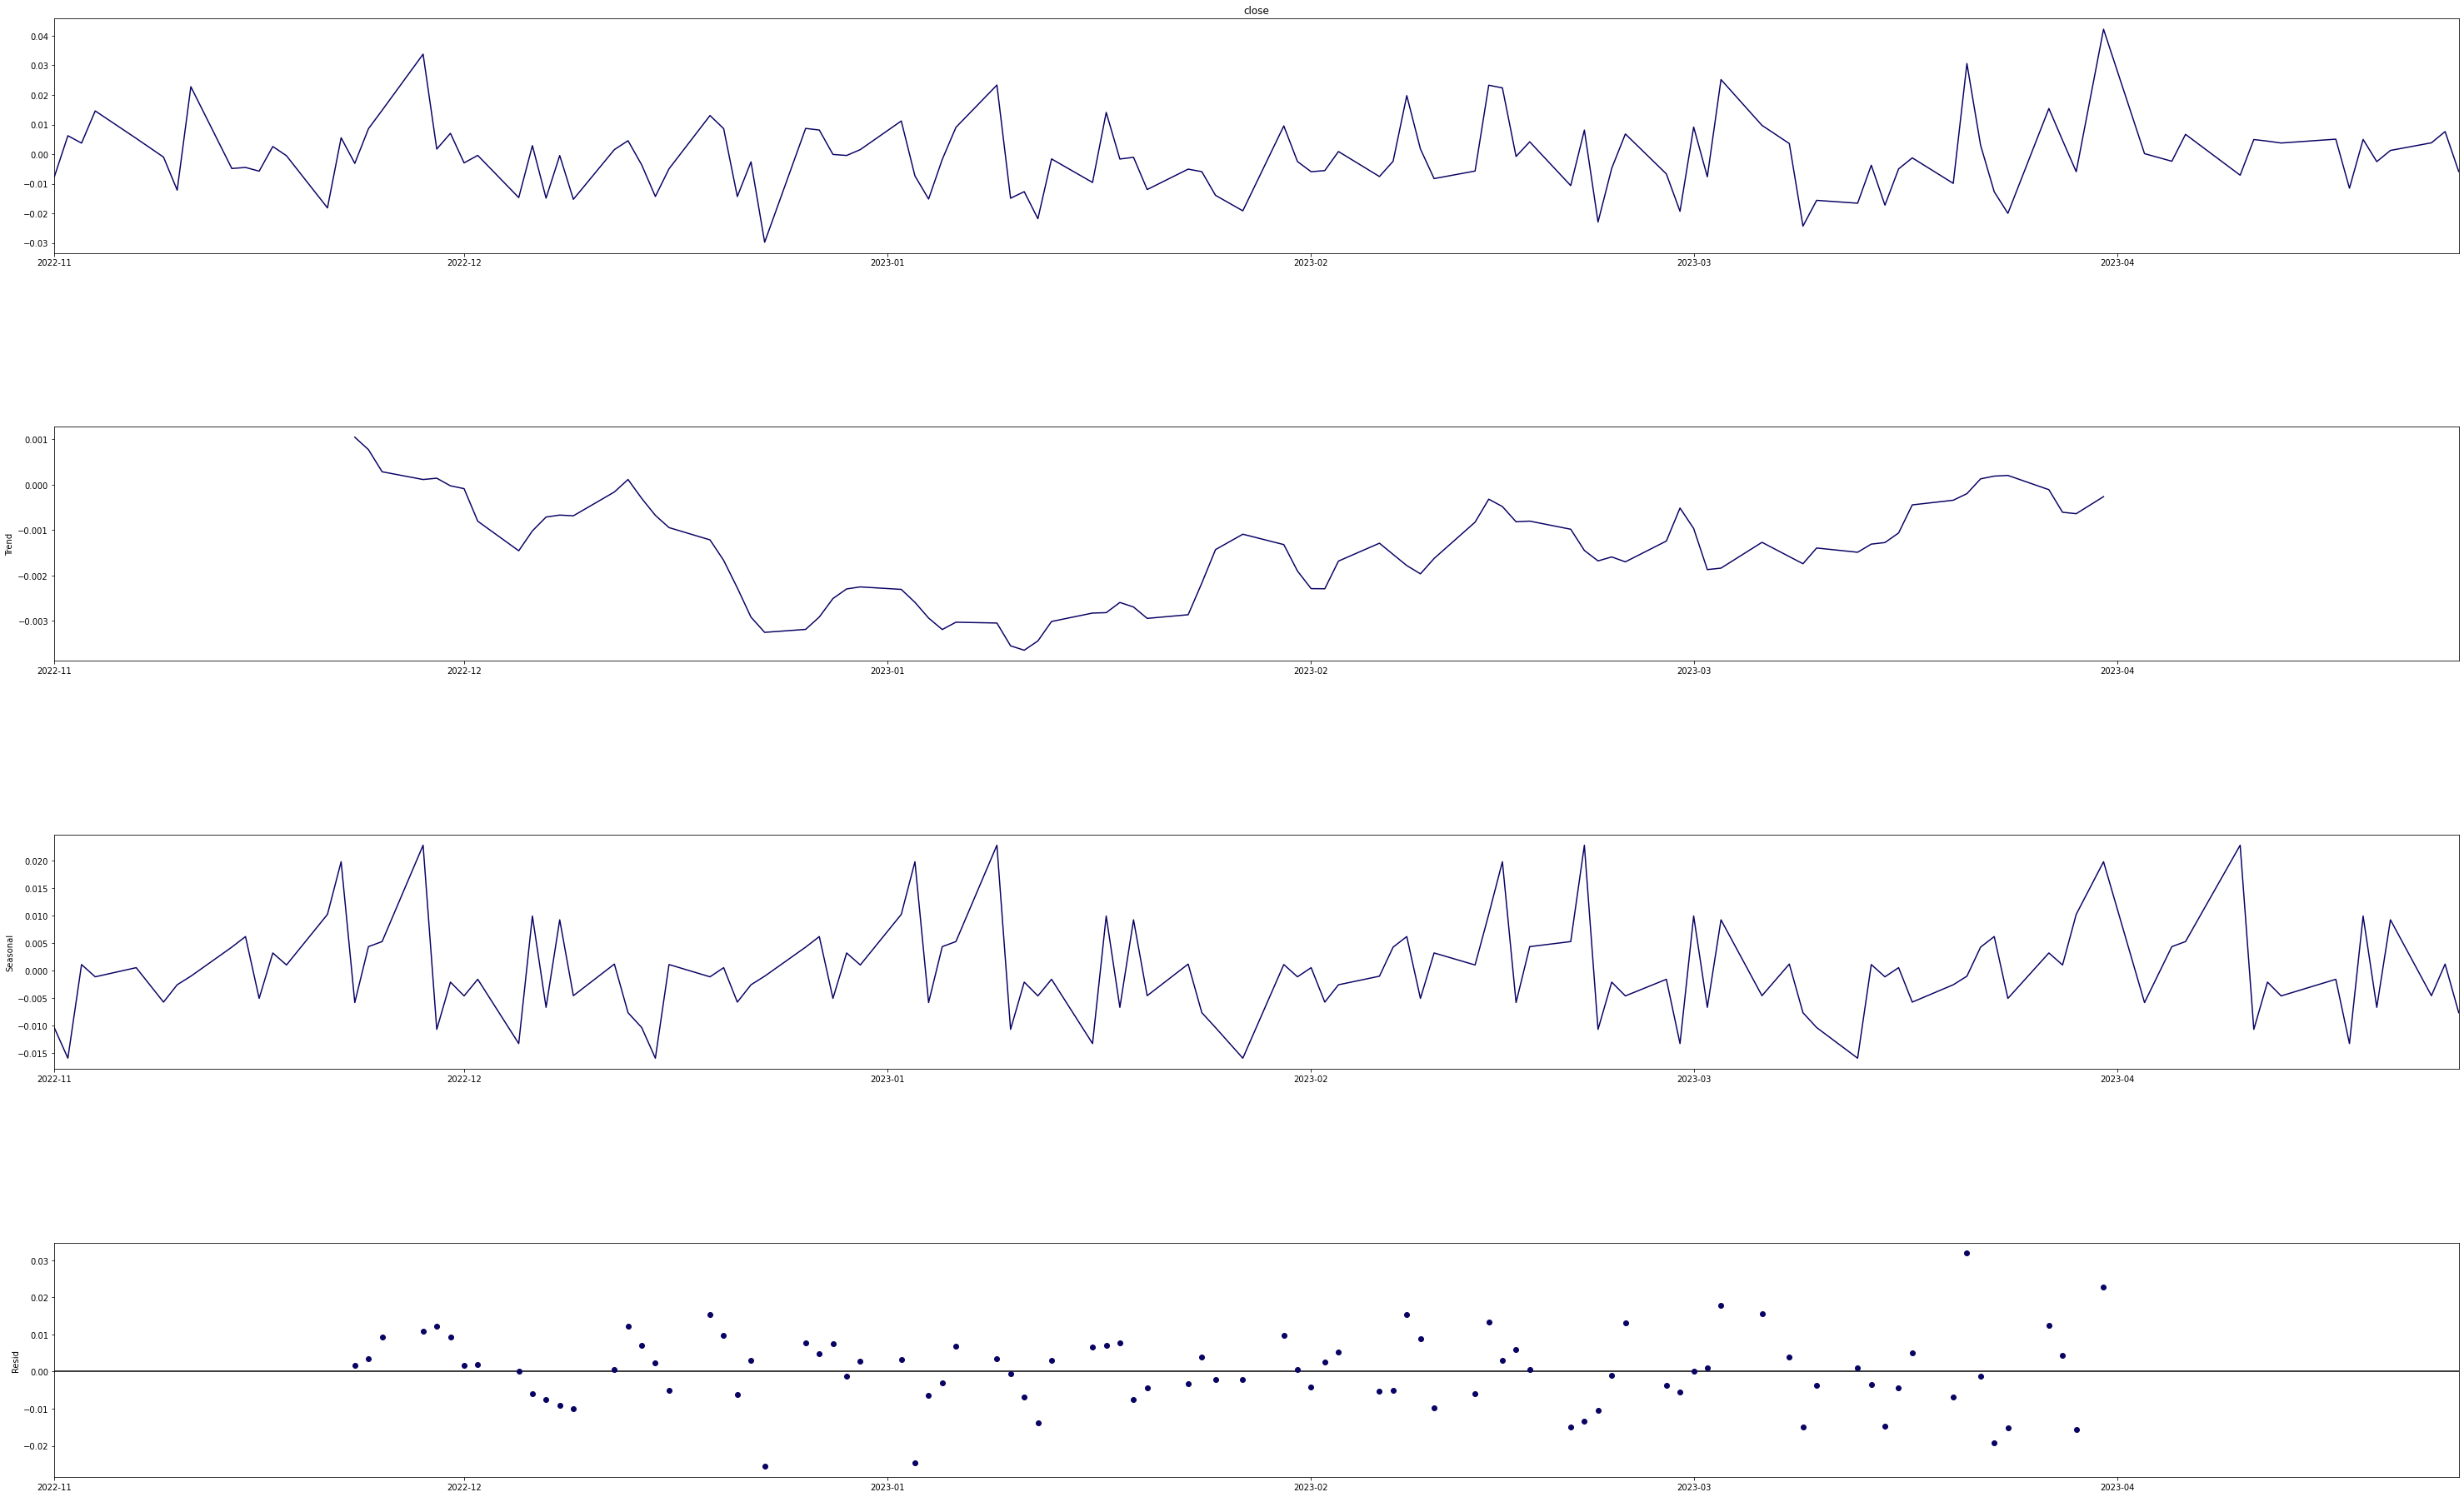

In [179]:
decompose_result = seasonal_decompose(logged_passengers_diff.tail(120), period=30)
fig=plt.figure()
fig=decompose_result.plot()
fig.set_size_inches(50,30)

In [210]:
prev_open = df['open'].tail(1).values
prev_close = df['close'].tail(1).values
prev_high = df['high'].tail(1).values
prev_low = df['low'].tail(1).values

In [217]:
Pivotpoint = (prev_high + prev_low + prev_close)/3
pp = Pivotpoint
pp

array([2367.41674805])

In [220]:
r1 = 2*pp - prev_low
r1

array([2380.78344727])

In [222]:
s1 = 2*pp - prev_high
s1

array([2348.73339844])

In [223]:
import pandas as pd
import quandl as qdl
from scipy.stats import linregress

# get AAPL 10 years data

data = qdl.get("WIKI/AAPL", start_date="2007-01-01", end_date="2017-05-01")

data0 = data.copy()
data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

# high trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Adj. High'],
                    )
    data1 = data1.loc[data1['Adj. High'] > reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Adj. High'],
                    )

data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]

# low trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Adj. Low'],
                    )
    data1 = data1.loc[data1['Adj. Low'] < reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Adj. Low'],
                    )

data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]

# plot

data0['Adj. Close'].plot()
data0['high_trend'].plot()
data0['low_trend'].plot()

ModuleNotFoundError: No module named 'quandl'